In [479]:
import pandas as pd
from catomatic.BinaryCatalogue import BinaryBuilder
from matplotlib_venn import venn2
import matplotlib.pyplot as plt
from protocols import utils
import os
import math
import pandas as pd
import numpy as np
import piezo

import warnings
from pathlib import Path
import json
import seaborn as sns

warnings.simplefilter("ignore", category=DeprecationWarning)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data Prep Functions

In [527]:
def read_data(file_path):
    """Reads .pkl, .pkl.gz, .csv, .csv.gz, or .parquet files automatically."""
    file_path = Path(file_path)
    ext = ''.join(file_path.suffixes).lower()  # Get full extension, e.g., ".pkl.gz"

    read_funcs = {
        ".pkl": pd.read_pickle,
        ".pkl.gz": pd.read_pickle,  # Supports compressed pickle
        ".csv": pd.read_csv,
        ".csv.gz": pd.read_csv,  # Supports compressed CSV
        ".parquet": pd.read_parquet
    }

    if ext in read_funcs:
        return read_funcs[ext](file_path)
    
    raise ValueError(f"Unsupported file type: {ext}")

def prep_phenotypes(drug, pheno_path, genomes_path, samples_path):
    #import phenotypes and samples and genoms
    phenotypes = read_data(pheno_path).reset_index()
    genomes = read_data(genomes_path).reset_index()
    samples = read_data(samples_path).reset_index()

    #ensure the tables all match - ie the number of matched samples (pheno-geno) is the same as that declared in the samples table
    #assert pd.merge(phenotypes, genomes, how='inner', on='UNIQUEID').UNIQUEID.nunique()==len(pd.merge(samples, genomes, how='inner', on='UNIQUEID')), 'There is a diferent number of matched phenotypes in samples table'
    
    #filter down to matched samples only - note there are fewer samples in dst table than dst_samples for crypticv1...
    matched = pd.merge(samples, genomes, how='inner', on='UNIQUEID').UNIQUEID.unique()
    phenotypes = phenotypes[phenotypes.UNIQUEID.isin(matched)]

    #filter for drug
    phenotypes = phenotypes[phenotypes.DRUG==drug]
    #discoard low quality phenotypes
    phenotypes = phenotypes[phenotypes.QUALITY.isin(['HIGH', 'MEDIUM', 'Unknown'])]
    #filter out non R/S phenotypes
    phenotypes = phenotypes[phenotypes.PHENOTYPE.isin(['R', 'S'])]
    #handle duplicates (keep R if R, otherwise first)
    phenotypes = phenotypes.groupby("UNIQUEID", group_keys=False).apply(utils.filter_multiple_phenos).reset_index(drop=True)
    # filter relevant columns for catomatic and rename id column
    phenotypes = phenotypes[['UNIQUEID', 'DRUG', 'PHENOTYPE']]

    return phenotypes

drug_genes = {
    "AMI": ["eis", "rrs"],
    "CAP": ["rrs", "tlyA"],
    "CIP": ["gyrA"],
    "DLM": ["ddn"],
    "EMB": ["embA", "embB"],
    "ETH": ["ethA", "fabG1", "inhA"],
    "INH": ["katG", "inhA", "ahpC", "fabG1"],
    "KAN": ["eis", "rrs"],
    "LEV": ["gyrA", "gyrB"],
    "LZD": ["rplC"],
    "MXF": ["gyrA", "gyrB"],
    "RIF": ["rpoB"],
    "STM": ["gid", "rpsL", "rrs"]
}

def prep_mutations(path, genes, train=True):
    #Uses most up to date mutations table, as this should contain all genomes from previous versions
    mut_path = f"{path}{'_'.join(genes)}_MUTATIONS.csv"
    var_path = f"{path}{'_'.join(genes)}_VARIANTS.csv"
    if not os.path.exists(mut_path):
        mutations = pd.read_parquet('data/cryptic-tables-v3.0.0-alpha.1/MUTATIONS.parquet').reset_index()
        variants = pd.read_parquet('data/cryptic-tables-v3.0.0-alpha.1/VARIANTS.parquet').reset_index()
        mutations[mutations.GENE.isin(genes)].to_csv(mut_path)
        variants[variants.GENE.isin(genes)].to_csv(var_path)

    mutations = pd.read_csv(mut_path)
    variants = pd.read_csv(var_path)

    variants["FRS"] = variants.apply(lambda row: row["MINOR_READS"] / row["COVERAGE"] if row["MINOR_READS"] > 0 else 1, axis=1) 

    mutations = pd.merge(mutations, variants[['UNIQUEID', 'GENE', 'GENE_POSITION', 'FRS']], on=['UNIQUEID', 'GENE', 'GENE_POSITION'], how='left')

    mutations = mutations[~mutations.IS_NULL]
    #create mutations columns in piezo grammar
    mutations['MUTATION'] = mutations.apply(
    lambda x: f"{x['GENE']}@{x['MINOR_MUTATION'] if x['IS_MINOR'] else x['MUTATION']}",
    axis=1,
    )
    #flag synonymous mutations
    mutations["IS_SYNONYMOUS"] = mutations["MUTATION"].apply(lambda x: x.split("@")[-1][0] == x.split("@")[-1][-1])
    #filter out synonymous mutations
    if train:
        #if validating, would keep synonymous mutations
        mutations = mutations[~mutations.IS_SYNONYMOUS]
    #drop duplicate entries 
    mutations = mutations.drop_duplicates(['UNIQUEID', 'MUTATION', 'FRS'], keep='first')
    # filter relevant columns for catomatic and rename id column
    mutations = mutations[['UNIQUEID', 'MUTATION', 'FRS']].rename(columns={'ENA_RUN': 'UNIQUEID'})
    return mutations




# Catalogue Construction workflow

The following functions are used to import the data tables, and prepare them for catomatic for a particular drug and defined set of candidate genes.

In [72]:
phenotypes = prep_phenotypes('RIF')
phenotypes

,UNIQUEID,DRUG,PHENOTYPE
0,site.00.subj.1000347.lab.H111540004.iso.1,RIF,R
1,site.00.subj.1000595.lab.H123460044.iso.1,RIF,R
2,site.00.subj.1004213.lab.H111060034.iso.1,RIF,R
3,site.00.subj.1004213.lab.H112000008.iso.1,RIF,R
4,site.00.subj.1004213.lab.H113100007.iso.1,RIF,R
...,...,...,...
36542,site.ENA.subj.SAMN08215478.lab.1.iso.1,RIF,R
36543,site.ENA.subj.SAMN08215479.lab.1.iso.1,RIF,S
36544,site.ENA.subj.SAMN08215480.lab.1.iso.1,RIF,S
36545,site.ENA.subj.SAMN08215481.lab.1.iso.1,RIF,S


In [73]:
mutations = prep_mutations('data/mutations-v3.0.0/', drug_genes["RIF"])
mutations

,UNIQUEID,MUTATION,FRS
0,site.02.subj.0069.lab.22A019.iso.1,rpoB@S450L,1.0
4,site.03.subj.6236-05_LIB12062.lab.6236-05_LIB1...,rpoB@S450L,1.0
5,site.04.subj.00255.lab.709124.iso.1,rpoB@S450L,1.0
8,site.06.subj.RLH_0305-14.lab.06MIL0297.iso.1,rpoB@c-61t,1.0
9,site.06.subj.RLH_0305-14.lab.06MIL0297.iso.1,rpoB@S450L,1.0
...,...,...,...
63917,site.10.subj.IE00889190.lab.IE00889190.iso.1,rpoB@S450L,1.0
63921,site.ENA.subj.SAMN05276469.lab.1.iso.1,rpoB@2546_ins_cgagga,1.0
63923,site.ENA.subj.SAMN01908758.lab.1.iso.1,rpoB@H445D,1.0
63925,site.10.subj.YA00084833.lab.YA00084833.iso.1,rpoB@c-61t,1.0


## Build a catalogue for rifampicin

In [82]:
catalogue = BinaryBuilder(samples=phenotypes, mutations=mutations, FRS=0.1).build(test='Binomial', background=0.2, strict_unlock=True, p=0.95)
catalogue_df = catalogue.build_piezo(genbank_ref='NC00962.3', catalogue_name='rif_demo', version='0.0', drug='RIF', wildcards="./data/wildcards/rif_wildcards.json", json_dumps=True)
catalogue_df.to_csv('./catalogues/temp/demo_rif_catalogue.csv')
catalogue_df

,GENBANK_REFERENCE,CATALOGUE_NAME,CATALOGUE_VERSION,CATALOGUE_GRAMMAR,PREDICTION_VALUES,DRUG,MUTATION,PREDICTION,SOURCE,EVIDENCE,OTHER
0,NC00962.3,rif_demo,0.0,GARC1,RUS,RIF,rpoB@c-61t,S,{},"{""proportion"": 0.007413087934560327, ""confiden...",{}
1,NC00962.3,rif_demo,0.0,GARC1,RUS,RIF,rpoB@2546_ins_cgagga,S,{},"{""proportion"": 0.0, ""confidence"": [-3.30391217...",{}
2,NC00962.3,rif_demo,0.0,GARC1,RUS,RIF,rpoB@S16C,S,{},"{""proportion"": 0.0, ""confidence"": [0.0, 0.1372...",{}
3,NC00962.3,rif_demo,0.0,GARC1,RUS,RIF,rpoB@E250G,S,{},"{""proportion"": 0.056818181818181816, ""confiden...",{}
4,NC00962.3,rif_demo,0.0,GARC1,RUS,RIF,rpoB@L449Q,S,{},"{""proportion"": 0.0, ""confidence"": [-3.26846996...",{}
...,...,...,...,...,...,...,...,...,...,...,...
410,NC00962.3,rif_demo,0.0,GARC1,RUS,RIF,rpoB@-*_indel,U,{},"{""default_rule"": ""True""}",{}
411,NC00962.3,rif_demo,0.0,GARC1,RUS,RIF,rpoB@*_indel,U,{},"{""default_rule"": ""True""}",{}
412,NC00962.3,rif_demo,0.0,GARC1,RUS,RIF,rpoB@-*?,U,{},"{""default_rule"": ""True""}",{}
413,NC00962.3,rif_demo,0.0,GARC1,RUS,RIF,rpoB@*?,U,{},"{""default_rule"": ""True""}",{}


In [83]:
catalogue_df.PREDICTION.value_counts()

PREDICTION
U    359
R     39
S     17
Name: count, dtype: int64

### Use the catalogue to predict phenotypes


Now that we have built a catalogue for rifampicin, we can apply a simple prediction algorithm to test its senstivity for predicting resistance.

We can do this on the same dataset used to build the catalogues, but crucially, we also have a totally independent validation set.

[[10302   404   240]
 [  384 24373   844]]
Catalogue coverage of isolates: 0.9703395627548089
Sensitivity: 0.9622641509433962
Specificity: 0.9844892353677748


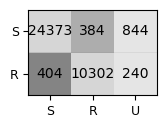

In [88]:
#test performance on training set

all = pd.merge(phenotypes, mutations[mutations.FRS>=0.1], on=['UNIQUEID'], how='left')
#note, this merge assumes the phenotypes df only contains samples that have been genotyped
cm = utils.piezo_predict(iso_df=all, drug='RIF', catalogue_file='./catalogues/temp/demo_rif_catalogue.csv', U_to_S=False, Print=True)[0]
cm = pd.DataFrame(cm, index=["R", "S"], columns=["R", "S", 'U'])

utils.plot_truthtables(cm, U_to_S=False, colors=["#666666", "#cccccc", "#999999", "#cccccc","#cccccc","#cccccc" ])

# Generate Catalogues for all drugs (parameter grid search)

There are a number of method-specific parameters that need to be optimised for each drug's data to generate a comprehensive catalogue. These include p-value of the statistical test, the background rate, and the fraction of read support for variants. 

FRS optimisation is a hot topic, and often reflects the essentiallity of the drug target. Therefore, this will be investigated seperately to the parameter search, after optimal background and p-values have been chosen.

In [497]:
#takes a while to run, so may want to split the predictions from the building step

def grid_search(mutations_dir, phenotypes_path, genomes_path, samples_path,catfile_dir, FRS):
    grid_results = {}
    for drug, genes in drug_genes.items():
        grid_results[drug] = {}
        mutations = prep_mutations(mutations_dir, genes, train=True)
        test_mutations = prep_mutations(mutations_dir, genes, train=False)
        phenotypes = prep_phenotypes(drug, phenotypes_path, genomes_path, samples_path)
        
        for background in [0.05, 0.10, 0.15, 0.20, 0.25]:
            for p in [0.9, 0.95]:
                # Specify path at which to save the catalogue
                catfile = f"{catfile_dir}/{drug.lower()}/bg_{background}_p_{p}_FRS_{FRS}.csv"
                if not os.path.exists(catfile):
                    # Generate and save the catalogue using this set of parameters
                    catalogue = BinaryBuilder(samples=phenotypes, mutations=mutations, FRS=FRS).build(test='Binomial', background=background, strict_unlock=True, p=p)
                    # Export the catalogue in piezo format
                    catalogue.to_piezo(genbank_ref='NC00962.3',catalogue_name=f'{drug}-{background}-{p}',version='0.0',drug=drug,wildcards=f"./data/wildcards/{drug.lower()}_wildcards.json",json_dumps=True,outfile=catfile)
                
                # Test the performance of this catalogue on the training set
                all = pd.merge(phenotypes, test_mutations[test_mutations.FRS >= 0.1], on=['UNIQUEID'], how='left')
                cm, cov, sens, spec, _, _ = utils.piezo_predict(iso_df=all, drug=drug, catalogue_file=catfile, U_to_S=False, Print=False)
                
                # Save results into grid_results
                if background not in grid_results[drug]:
                    grid_results[drug][background] = {}
                grid_results[drug][background][p] = {"cm": cm, "cov": cov, "sens": sens,"spec": spec}

    return grid_results



OUTFILE catalogues/cryptic-v3.0.0/grid_search//ami/bg_0.1_p_0.9_FRS_0.1.csv
OUTFILE catalogues/cryptic-v3.0.0/grid_search//ami/bg_0.1_p_0.95_FRS_0.1.csv


KeyboardInterrupt: 

In [ ]:
grid_results = grid_search(
    "data/mutations-v3.0.0/",
    "data/cryptic-tables-v3.0.0-alpha.1/DST_MEASUREMENTS.pkl.gz",
    "data/cryptic-tables-v3.0.0-alpha.1/GENOMES.parquet",
    "data/cryptic-tables-v3.0.0-alpha.1/DST_SAMPLES.parquet",
    "catalogues/cryptic-v3.0.0/grid_search/",
    0.1,
)


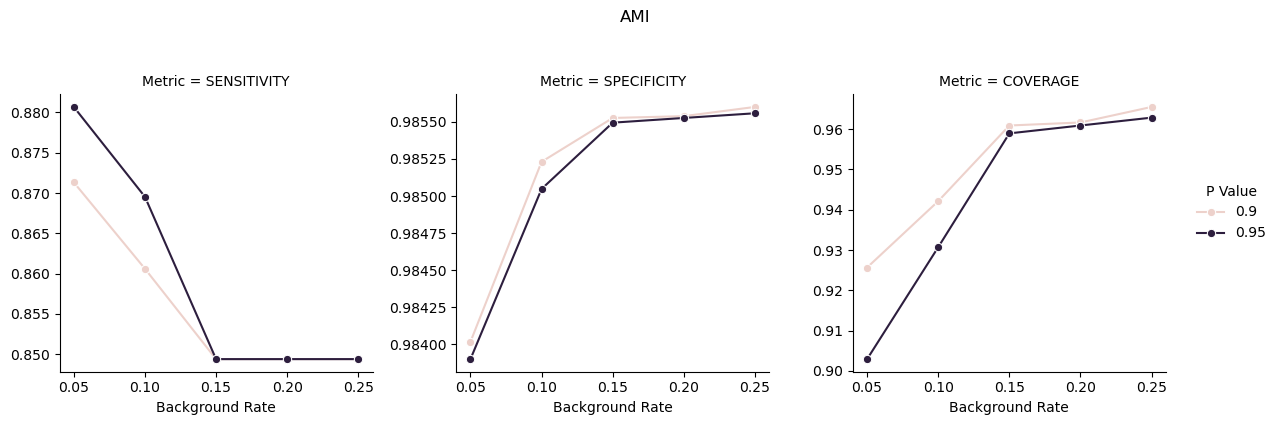

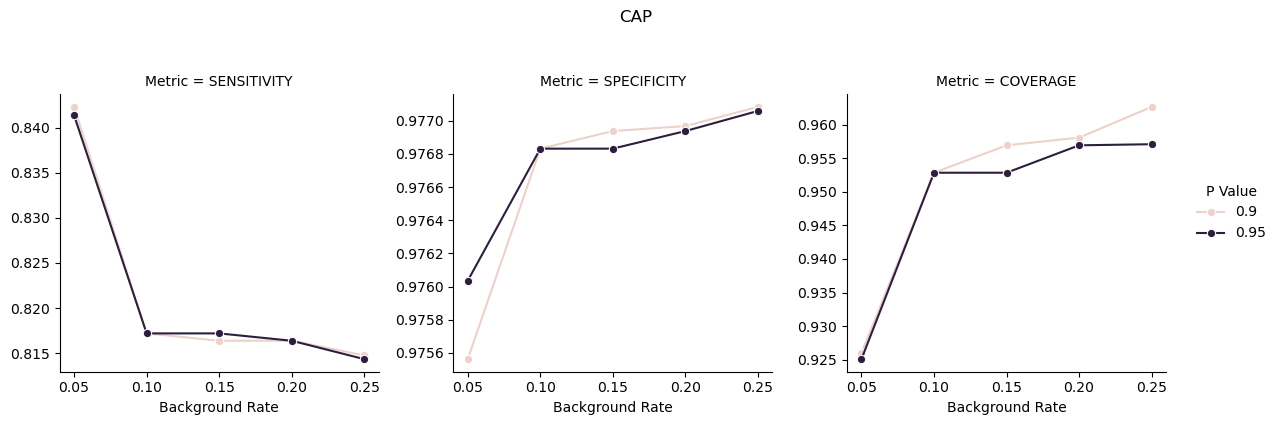

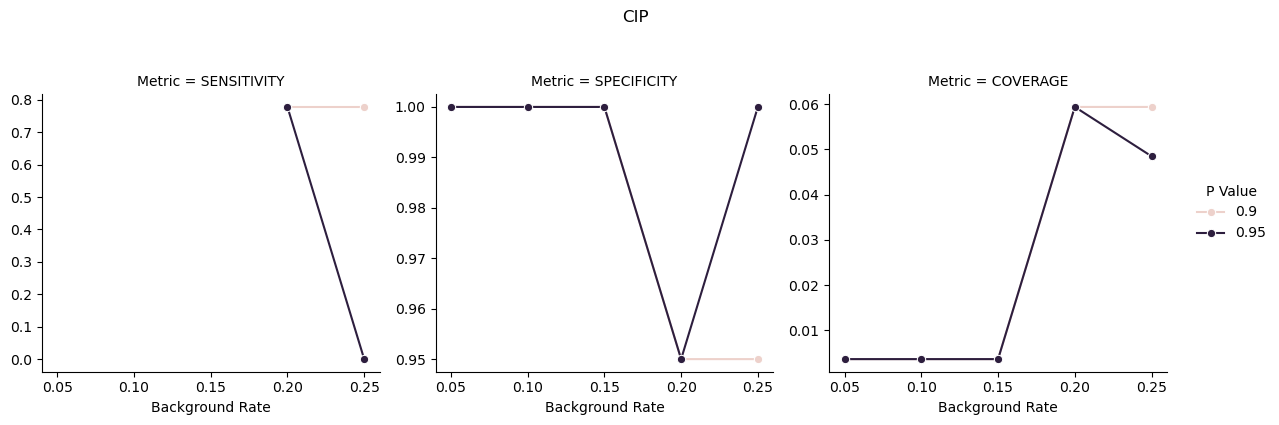

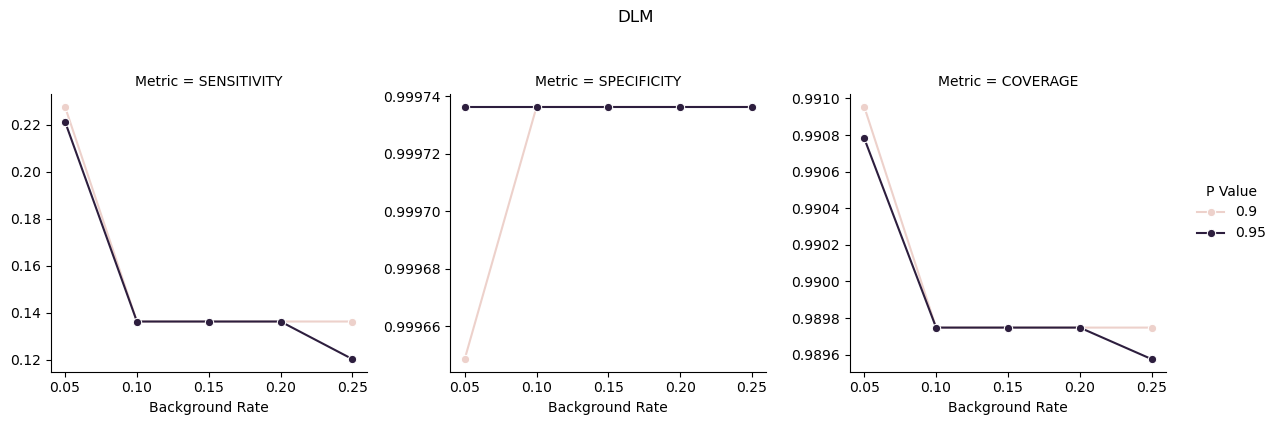

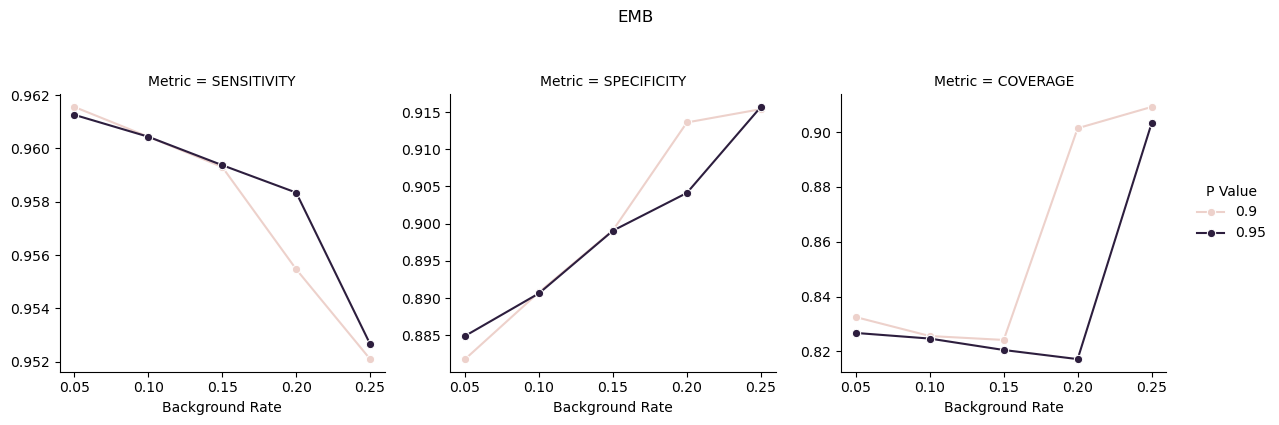

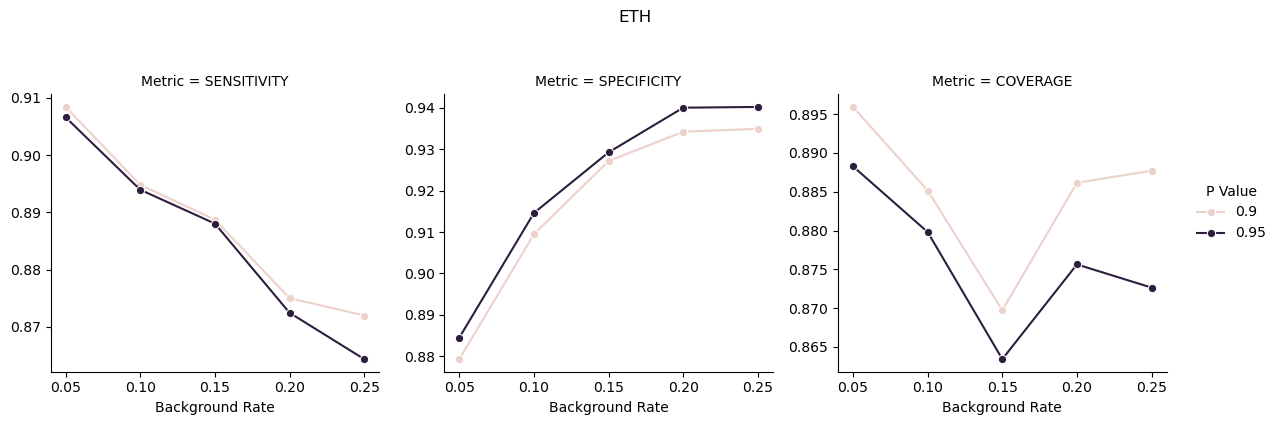

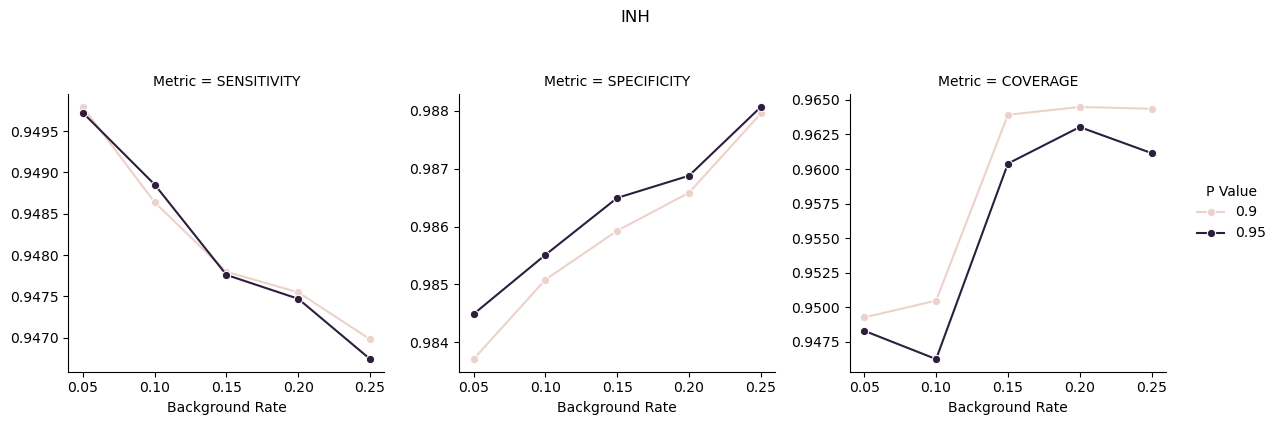

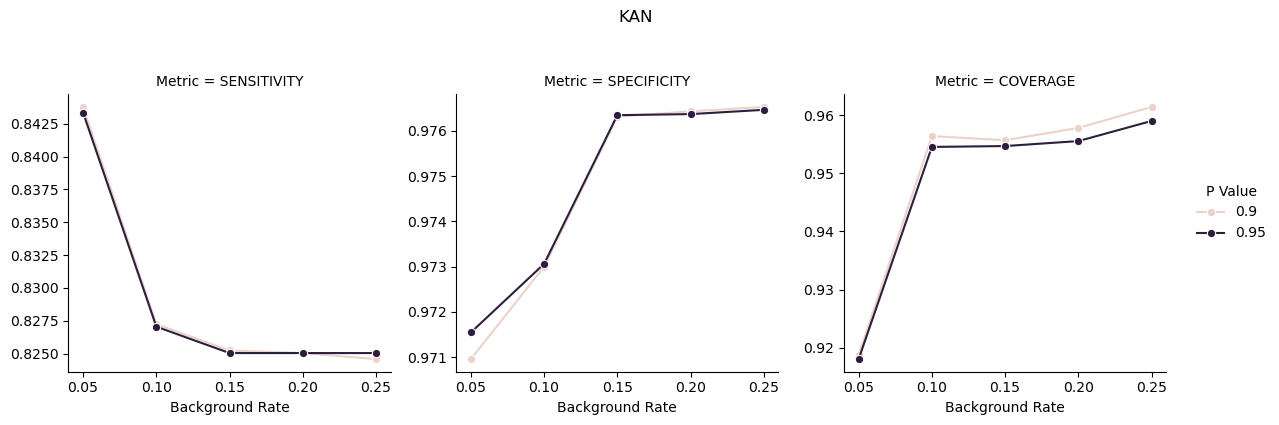

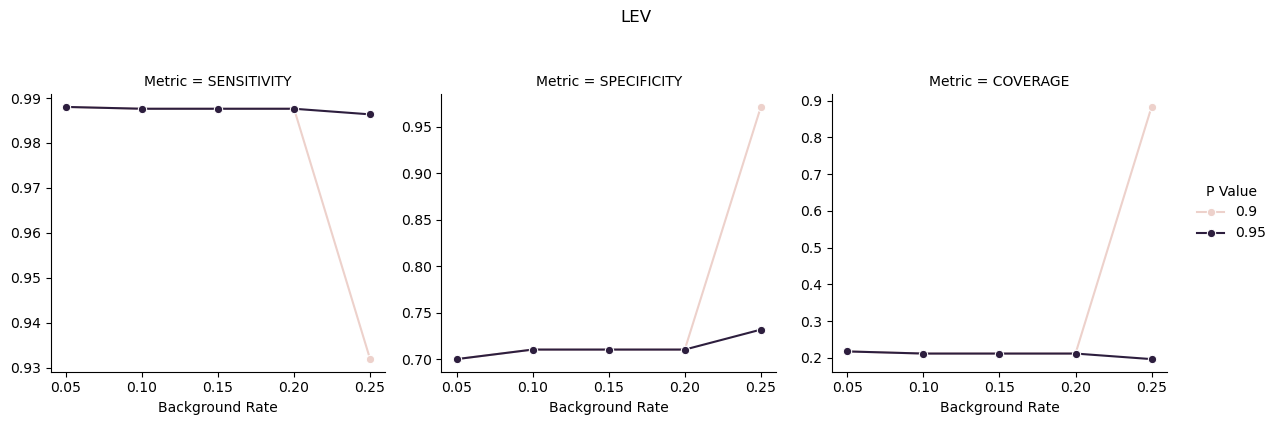

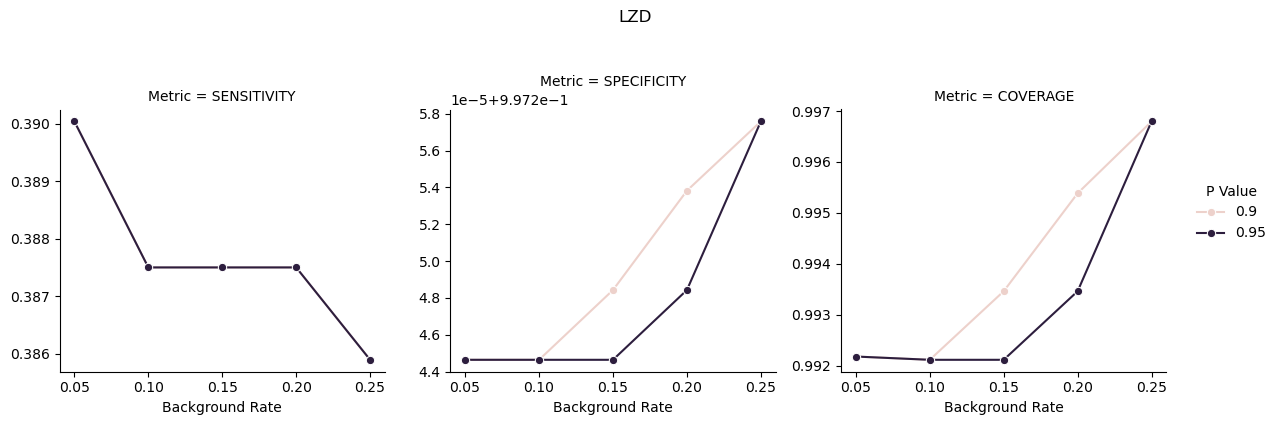

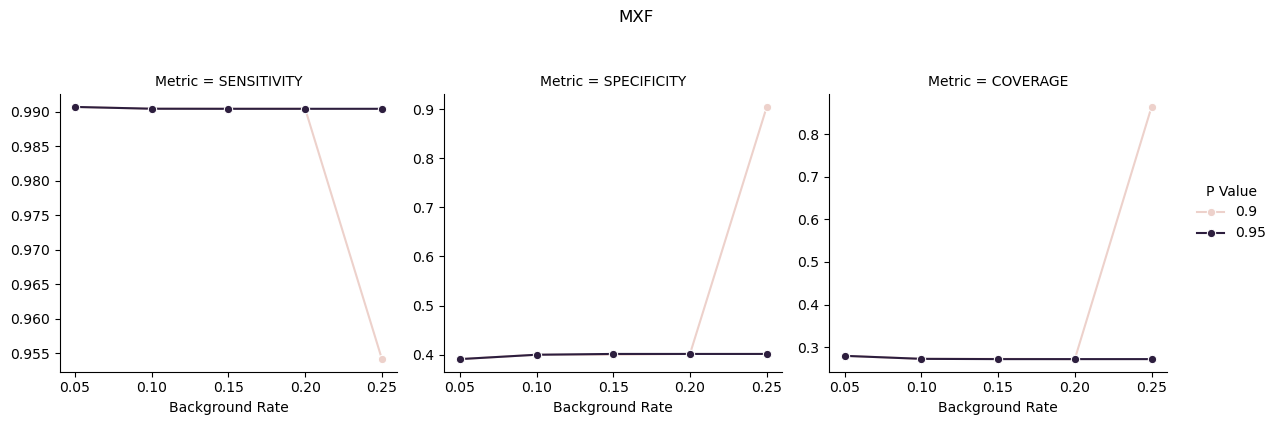

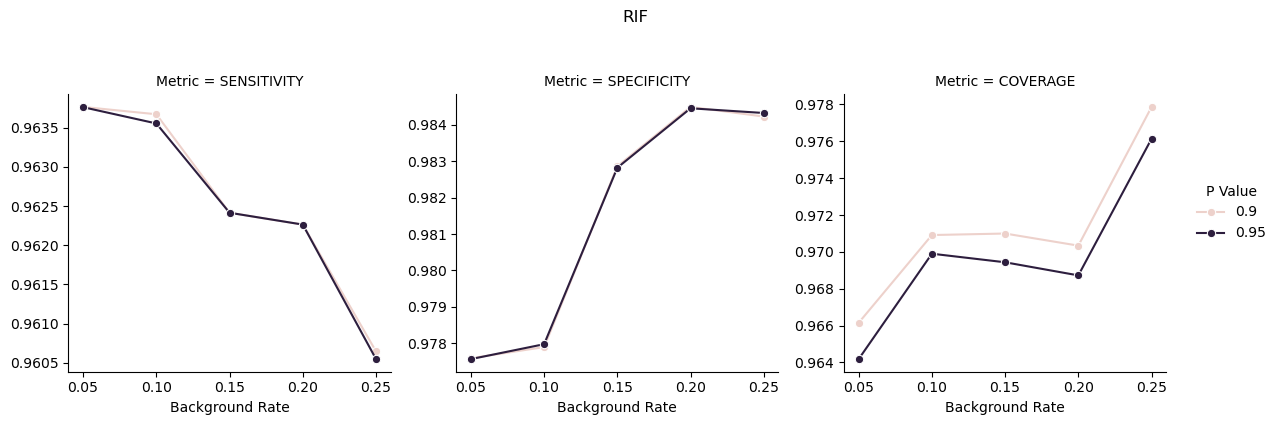

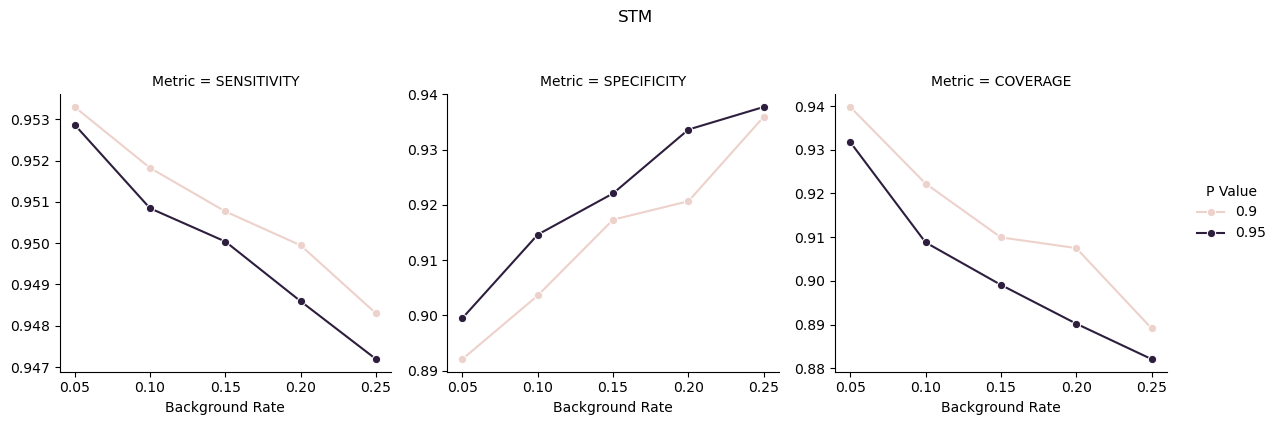

In [ ]:

# Flatten the grid_results dictionary into a DataFrame
def flatten_grid_results(grid):
    return pd.DataFrame(
    [
        {
            "DRUG": drug,
            "BACKGROUND_RATE": background_rate,
            "p_value": p,
            "SENSITIVITY": metrics.get("sens"),
            "SPECIFICITY": metrics.get("spec"),
            "COVERAGE": metrics.get("cov"),
        }
        for drug, backgrounds in grid.items()
        for background_rate, p_values in backgrounds.items()
        for p, metrics in p_values.items()
    ]
)

df = flatten_grid_results(grid_results)

# Melt the DataFrame for plotting
melted_df = df.melt(
    id_vars=["DRUG", "BACKGROUND_RATE", "p_value"],
    value_vars=["SENSITIVITY", "SPECIFICITY", "COVERAGE"],
    var_name="Metric",
    value_name="Value",
)

for drug in melted_df["DRUG"].unique():
    drug_data = melted_df[melted_df["DRUG"] == drug]
    g = sns.FacetGrid(drug_data, col="Metric", col_wrap=3, sharey=False, height=4)
    g.map_dataframe(
        sns.lineplot, x="BACKGROUND_RATE", y="Value", hue="p_value", marker="o"
    )
    g.set_axis_labels("Background Rate", "")
    g.add_legend(title="P Value")
    g.figure.suptitle(drug, y=1.05)
    g.tight_layout()
    plt.show()

In [112]:
#determine best performing catalogue
opt_cats = utils.weighted_score(df).groupby("DRUG").head(1).reset_index(drop=True)
#pull out R, S, U counts from catalogue
cat_counts = pd.DataFrame([
    {
        "DRUG": opt_cats['DRUG'][i],
        "R": cat["PREDICTION"].value_counts().get("R", 0),
        "S": cat["PREDICTION"].value_counts().get("S", 0),
        "U": cat["PREDICTION"].value_counts().get("U", 0),
        "Total": len(cat)
    }
    for i in opt_cats.index
    for cat in [pd.read_csv(f"./catalogues/cryptic-v3.0.0/grid_search/{opt_cats['DRUG'][i].lower()}/bg_{opt_cats['BACKGROUND_RATE'][i]}_p_{opt_cats['p_value'][i]}_FRS_0.1.csv")]
])

opt_cats = pd.merge(opt_cats, cat_counts, on='DRUG')
opt_cats['catalogue'] = 'catomatic'
opt_cats

,DRUG,BACKGROUND_RATE,p_value,SENSITIVITY,SPECIFICITY,COVERAGE,Score,R,S,U,Total,catalogue
0,RIF,0.25,0.90,0.960647,0.984225,0.977864,0.971164,46,22,366,434,catomatic
1,INH,0.25,0.90,0.946980,0.987956,0.964361,0.962749,57,23,629,709,catomatic
2,LEV,0.25,0.90,0.931926,0.971409,0.882963,0.933978,12,17,307,336,catomatic
3,STM,0.25,0.90,0.948299,0.935951,0.889144,0.932764,70,12,553,635,catomatic
4,EMB,0.25,0.90,0.952100,0.915381,0.909187,0.932502,17,58,978,1053,catomatic
5,MXF,0.25,0.90,0.954122,0.904579,0.864128,0.921260,11,19,369,399,catomatic
6,AMI,0.10,0.95,0.869533,0.985048,0.930712,0.916423,3,11,400,414,catomatic
7,CAP,0.05,0.90,0.842311,0.975562,0.925974,0.899019,57,4,253,314,catomatic
8,KAN,0.25,0.90,0.824581,0.976527,0.961450,0.897538,7,20,398,425,catomatic
9,ETH,0.10,0.95,0.893939,0.914619,0.879801,0.897316,131,5,561,697,catomatic


## vs FRS

In [457]:
results = {}

for i in range(len(opt_cats)):
    drug = opt_cats['DRUG'].iloc[i]
    mutations = prep_mutations('data/mutations-v3.0.0/',drug_genes[drug], train=True)
    test_mutations = prep_mutations('data/mutations-v3.0.0/',drug_genes[drug], train=False)
    phenotypes = prep_phenotypes(drug)
    results[drug] = {}
    for FRS in np.arange(0.1, 1, 0.1):
        catalogue_name = f"{drug}-{int(FRS*100)}-2025.02"
        background = opt_cats[opt_cats.DRUG==drug]['BACKGROUND_RATE'].iloc[0]
        p = opt_cats[opt_cats.DRUG==drug]['p_value'].iloc[0]
        catfile = (f"./catalogues/frs/{drug.lower()}/bg_{background}_"
                 f"p_{p}_FRS_{FRS}.csv")
        
        catalogue = BinaryBuilder(samples=phenotypes, mutations=mutations, FRS=FRS).build(test='Binomial', background=background, strict_unlock=True, p=p)
        # Export the catalogue in piezo format
        catalogue.to_piezo(genbank_ref='NC00962.3',catalogue_name=f'{drug}-{background}-{p}-{FRS}',version='0.0',drug=drug,wildcards=f"./data/wildcards/{drug.lower()}_wildcards.json",json_dumps=True,outfile=catfile)
        
        # Test the performance of this catalogue on the training set
        all = pd.merge(phenotypes, test_mutations, on=['UNIQUEID'], how='left')
        cm, cov, sens, spec, _, _ = utils.piezo_predict(iso_df=all, drug=drug, catalogue_file=catfile, U_to_S=False, Print=False)
        
        results[drug][FRS] = {"cm": cm, "cov": cov, "sens": sens,"spec": spec}

OUTFILE ./catalogues/frs/rif/bg_0.25_p_0.9_FRS_0.1.csv
OUTFILE ./catalogues/frs/rif/bg_0.25_p_0.9_FRS_0.2.csv
OUTFILE ./catalogues/frs/rif/bg_0.25_p_0.9_FRS_0.30000000000000004.csv
OUTFILE ./catalogues/frs/rif/bg_0.25_p_0.9_FRS_0.4.csv
OUTFILE ./catalogues/frs/rif/bg_0.25_p_0.9_FRS_0.5.csv
OUTFILE ./catalogues/frs/rif/bg_0.25_p_0.9_FRS_0.6000000000000001.csv
OUTFILE ./catalogues/frs/rif/bg_0.25_p_0.9_FRS_0.7000000000000001.csv
OUTFILE ./catalogues/frs/rif/bg_0.25_p_0.9_FRS_0.8.csv
OUTFILE ./catalogues/frs/rif/bg_0.25_p_0.9_FRS_0.9.csv
OUTFILE ./catalogues/frs/inh/bg_0.25_p_0.9_FRS_0.1.csv
OUTFILE ./catalogues/frs/inh/bg_0.25_p_0.9_FRS_0.2.csv
OUTFILE ./catalogues/frs/inh/bg_0.25_p_0.9_FRS_0.30000000000000004.csv
OUTFILE ./catalogues/frs/inh/bg_0.25_p_0.9_FRS_0.4.csv
OUTFILE ./catalogues/frs/inh/bg_0.25_p_0.9_FRS_0.5.csv
OUTFILE ./catalogues/frs/inh/bg_0.25_p_0.9_FRS_0.6000000000000001.csv
OUTFILE ./catalogues/frs/inh/bg_0.25_p_0.9_FRS_0.7000000000000001.csv
OUTFILE ./catalogues/frs/inh

/var/folders/s5/pshvb2093574r5hqnwcy6klw0000gn/T/ipykernel_66892/1875308441.py:50: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  mutations = pd.read_csv(mut_path)
/var/folders/s5/pshvb2093574r5hqnwcy6klw0000gn/T/ipykernel_66892/1875308441.py:51: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  variants = pd.read_csv(var_path)


OUTFILE ./catalogues/frs/cip/bg_0.25_p_0.9_FRS_0.1.csv
OUTFILE ./catalogues/frs/cip/bg_0.25_p_0.9_FRS_0.2.csv
OUTFILE ./catalogues/frs/cip/bg_0.25_p_0.9_FRS_0.30000000000000004.csv
OUTFILE ./catalogues/frs/cip/bg_0.25_p_0.9_FRS_0.4.csv
OUTFILE ./catalogues/frs/cip/bg_0.25_p_0.9_FRS_0.5.csv
OUTFILE ./catalogues/frs/cip/bg_0.25_p_0.9_FRS_0.6000000000000001.csv
OUTFILE ./catalogues/frs/cip/bg_0.25_p_0.9_FRS_0.7000000000000001.csv
OUTFILE ./catalogues/frs/cip/bg_0.25_p_0.9_FRS_0.8.csv
OUTFILE ./catalogues/frs/cip/bg_0.25_p_0.9_FRS_0.9.csv
OUTFILE ./catalogues/frs/dlm/bg_0.05_p_0.9_FRS_0.1.csv
OUTFILE ./catalogues/frs/dlm/bg_0.05_p_0.9_FRS_0.2.csv
OUTFILE ./catalogues/frs/dlm/bg_0.05_p_0.9_FRS_0.30000000000000004.csv
OUTFILE ./catalogues/frs/dlm/bg_0.05_p_0.9_FRS_0.4.csv
OUTFILE ./catalogues/frs/dlm/bg_0.05_p_0.9_FRS_0.5.csv
OUTFILE ./catalogues/frs/dlm/bg_0.05_p_0.9_FRS_0.6000000000000001.csv
OUTFILE ./catalogues/frs/dlm/bg_0.05_p_0.9_FRS_0.7000000000000001.csv
OUTFILE ./catalogues/frs/dlm

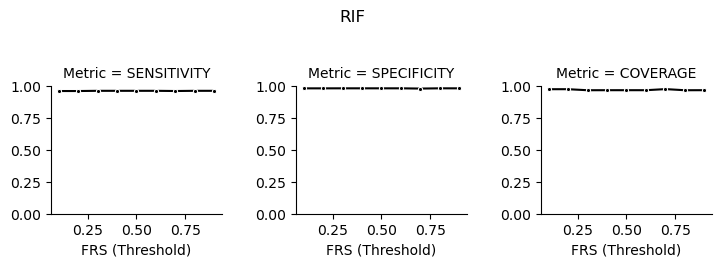

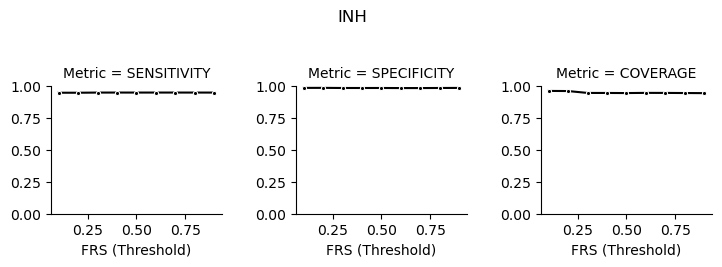

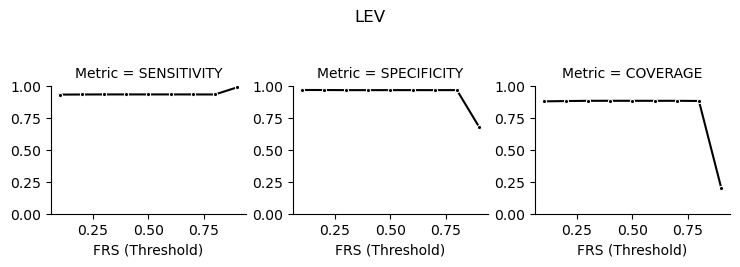

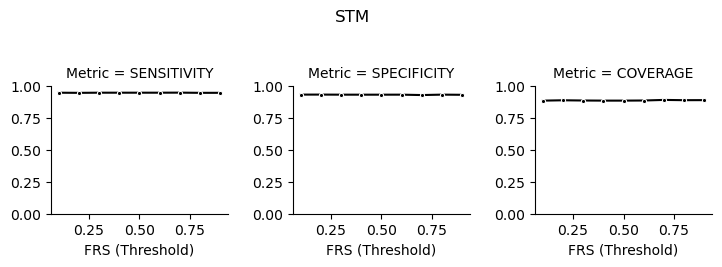

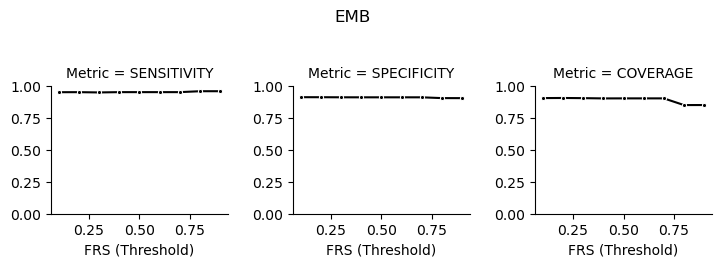

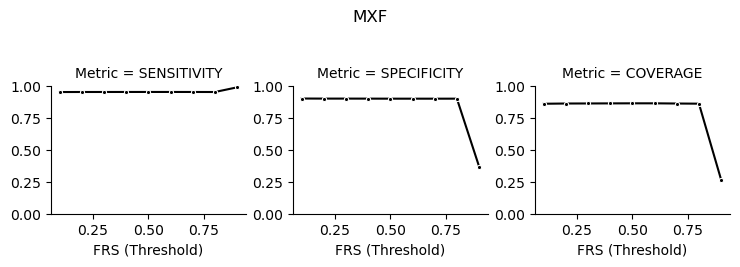

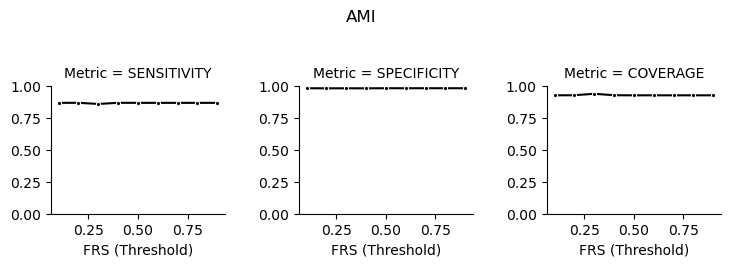

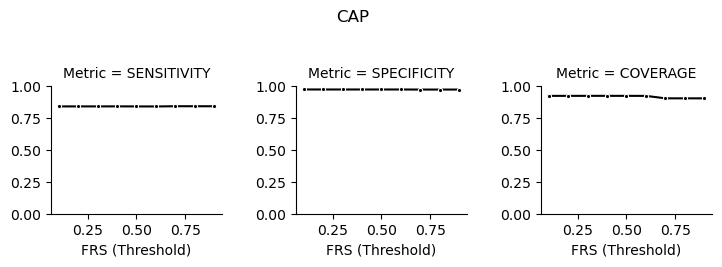

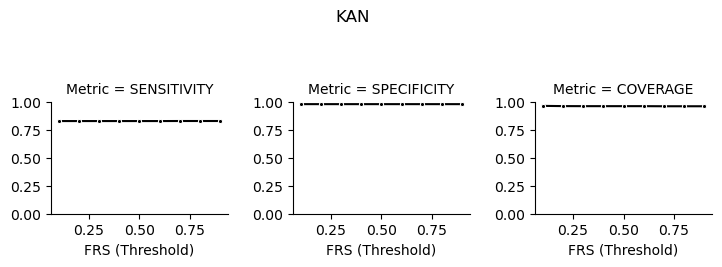

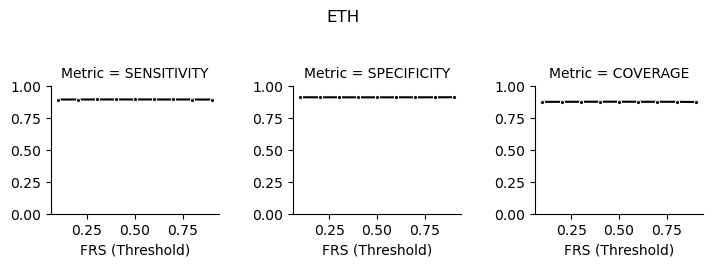

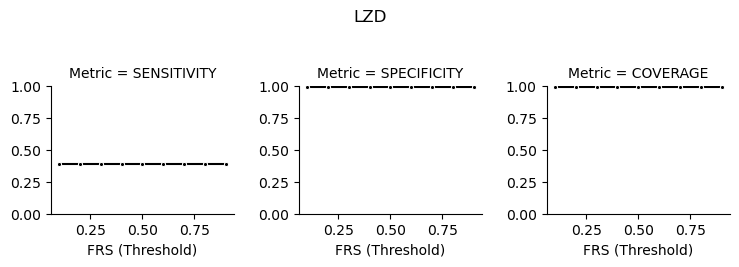

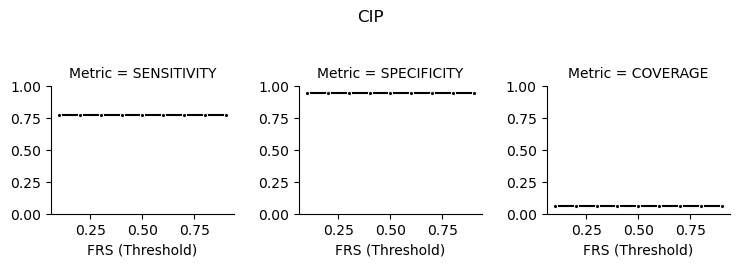

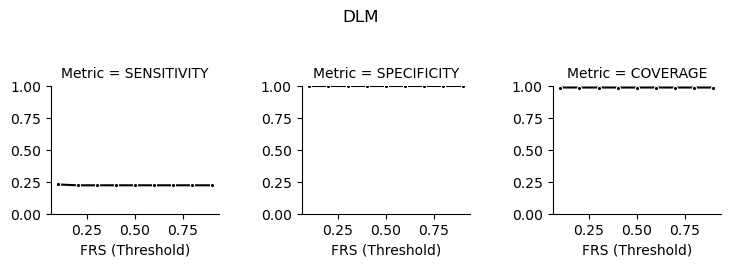

In [ ]:
data = []
for drug, thresholds in results.items():
    for threshold, metrics in thresholds.items():
        data.append({
            "DRUG": drug,
            "THRESHOLD": float(threshold),  
            "SENSITIVITY": metrics["sens"],
            "SPECIFICITY": metrics["spec"],
            "COVERAGE": metrics["cov"],
            "CM": metrics["cm"], 
        })

df = pd.DataFrame(data)

melted_df = df.melt(
    id_vars=["DRUG", "THRESHOLD"],  # Keeping only DRUG and THRESHOLD
    value_vars=["SENSITIVITY", "SPECIFICITY", "COVERAGE"],
    var_name="Metric",
    value_name="Value",
)

# Plot for each drug
for drug in melted_df["DRUG"].unique():
    drug_data = melted_df[melted_df["DRUG"] == drug]
    g = sns.FacetGrid(drug_data, col="Metric", col_wrap=3, sharey=False, height=2.5)
    g.map_dataframe(sns.lineplot, x="THRESHOLD", y="Value", marker=".", color='black')
    g.set_axis_labels("FRS (Threshold)", "")
    g.figure.suptitle(drug, y=1.05)
    g.tight_layout()
    g.set(ylim=(0, 1))
    plt.show()

Doesn't look like varying the FRS during the building step has much of an impact, which is interesting... For now just keep FRS low at 0.1 to capture as many variants as possible.

# Performance Benchmarking

Because the WHO catalogues have been parsed into a piezo format, we can easily run predictions from them on our training set (or any tarining set) and compare performance with catomatic's catalogues.

However, the WHO use a binary prediction system, whereby samples containing U mutations are assumed to be S (ie those mutations are removed). However, we can ignore this and use a ternary system to compare to ours (which will also be more informative as it will tell us how many WHO predictions are actual look-ups, and how many are assumptions).

WHOv1 was training on cryptic-v1, therefore training catoamtic on this dataset would provide a nice like-for-like comparison to the WHO method.

##### Catalogues to compare:

- whov1
- whov2
- catomaticv1 (built on same dataset as whov1)
- catomaticv3

##### Test sets (may not need to compare all catalogues at same time. )
- catomatic-crypticv1 (training set for whov1 and catomatic-crypticv1 - allows only head-to-head training comp)
- validation set (for now just use crypticv3 training set as placeholder)



##### Build and optimise catomatic on cryptic-v1

In [532]:
#Generate catomatic catalogue on cryptic v1
grid_results_v1 =  grid_search(
    "data/mutations-v1/",
    "data/cryptic-tables-v3.0.0-alpha.1/DST_MEASUREMENTS.pkl.gz",
    "data/cryptic-tables-v1/GENOMES.pkl.gz",
    "data/cryptic-tables-v1/DST_SAMPLES.csv.gz",
    "catalogues/cryptic-v1/grid_search/",
    0.1,
)


OUTFILE catalogues/cryptic-v1/grid_search//ami/bg_0.15_p_0.9_FRS_0.1.csv
OUTFILE catalogues/cryptic-v1/grid_search//ami/bg_0.15_p_0.95_FRS_0.1.csv
OUTFILE catalogues/cryptic-v1/grid_search//ami/bg_0.2_p_0.9_FRS_0.1.csv
OUTFILE catalogues/cryptic-v1/grid_search//ami/bg_0.2_p_0.95_FRS_0.1.csv
OUTFILE catalogues/cryptic-v1/grid_search//ami/bg_0.25_p_0.9_FRS_0.1.csv
OUTFILE catalogues/cryptic-v1/grid_search//ami/bg_0.25_p_0.95_FRS_0.1.csv
OUTFILE catalogues/cryptic-v1/grid_search//cap/bg_0.05_p_0.9_FRS_0.1.csv
OUTFILE catalogues/cryptic-v1/grid_search//cap/bg_0.05_p_0.95_FRS_0.1.csv
OUTFILE catalogues/cryptic-v1/grid_search//cap/bg_0.1_p_0.9_FRS_0.1.csv
OUTFILE catalogues/cryptic-v1/grid_search//cap/bg_0.1_p_0.95_FRS_0.1.csv
OUTFILE catalogues/cryptic-v1/grid_search//cap/bg_0.15_p_0.9_FRS_0.1.csv
OUTFILE catalogues/cryptic-v1/grid_search//cap/bg_0.15_p_0.95_FRS_0.1.csv
OUTFILE catalogues/cryptic-v1/grid_search//cap/bg_0.2_p_0.9_FRS_0.1.csv
OUTFILE catalogues/cryptic-v1/grid_search//cap/bg_

/var/folders/s5/pshvb2093574r5hqnwcy6klw0000gn/T/ipykernel_66892/4143110092.py:71: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  mutations = pd.read_csv(mut_path)
/var/folders/s5/pshvb2093574r5hqnwcy6klw0000gn/T/ipykernel_66892/4143110092.py:72: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  variants = pd.read_csv(var_path)


OUTFILE catalogues/cryptic-v1/grid_search//cip/bg_0.05_p_0.9_FRS_0.1.csv
OUTFILE catalogues/cryptic-v1/grid_search//cip/bg_0.05_p_0.95_FRS_0.1.csv
OUTFILE catalogues/cryptic-v1/grid_search//cip/bg_0.1_p_0.9_FRS_0.1.csv
OUTFILE catalogues/cryptic-v1/grid_search//cip/bg_0.1_p_0.95_FRS_0.1.csv
OUTFILE catalogues/cryptic-v1/grid_search//cip/bg_0.15_p_0.9_FRS_0.1.csv
OUTFILE catalogues/cryptic-v1/grid_search//cip/bg_0.15_p_0.95_FRS_0.1.csv
OUTFILE catalogues/cryptic-v1/grid_search//cip/bg_0.2_p_0.9_FRS_0.1.csv
OUTFILE catalogues/cryptic-v1/grid_search//cip/bg_0.2_p_0.95_FRS_0.1.csv
OUTFILE catalogues/cryptic-v1/grid_search//cip/bg_0.25_p_0.9_FRS_0.1.csv
OUTFILE catalogues/cryptic-v1/grid_search//cip/bg_0.25_p_0.95_FRS_0.1.csv
OUTFILE catalogues/cryptic-v1/grid_search//dlm/bg_0.05_p_0.9_FRS_0.1.csv
OUTFILE catalogues/cryptic-v1/grid_search//dlm/bg_0.05_p_0.95_FRS_0.1.csv
OUTFILE catalogues/cryptic-v1/grid_search//dlm/bg_0.1_p_0.9_FRS_0.1.csv
OUTFILE catalogues/cryptic-v1/grid_search//dlm/bg_

NameError: name 'flatten_grid_results' is not defined

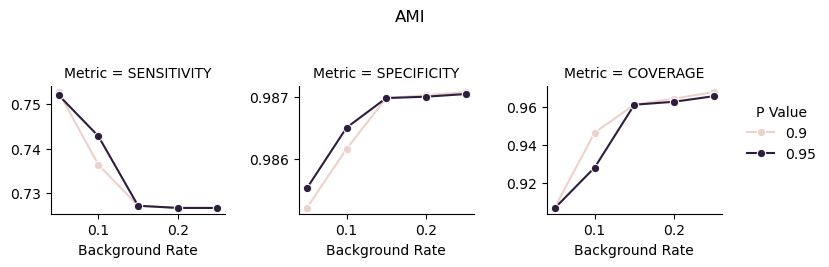

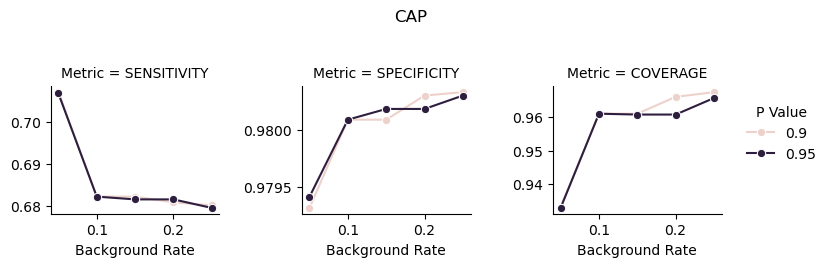

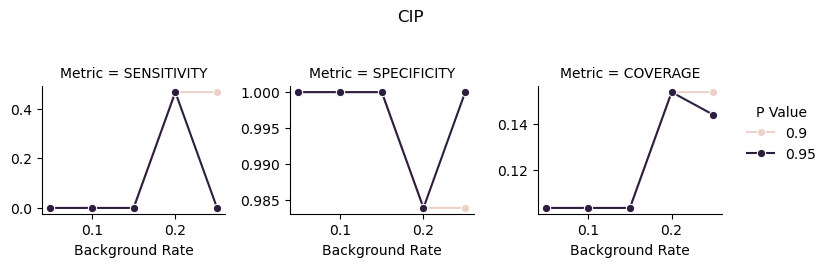

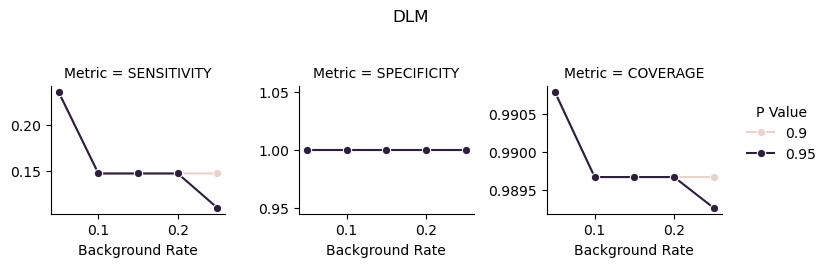

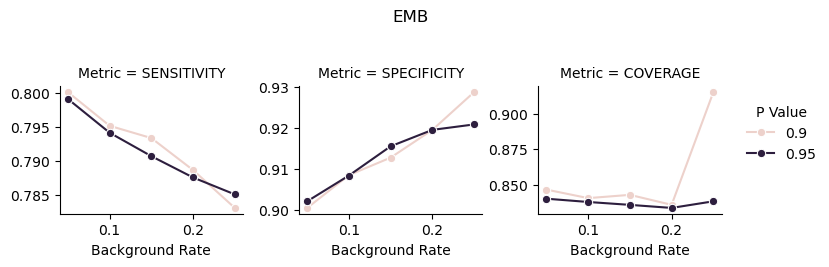

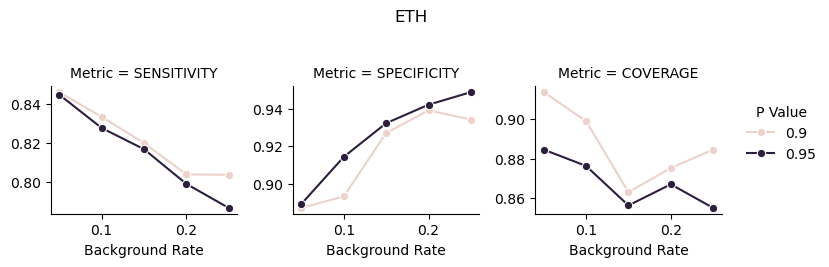

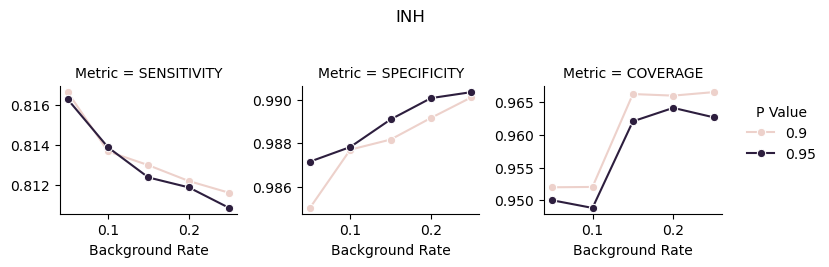

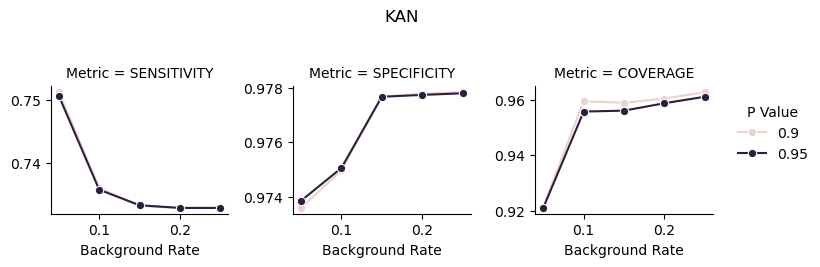

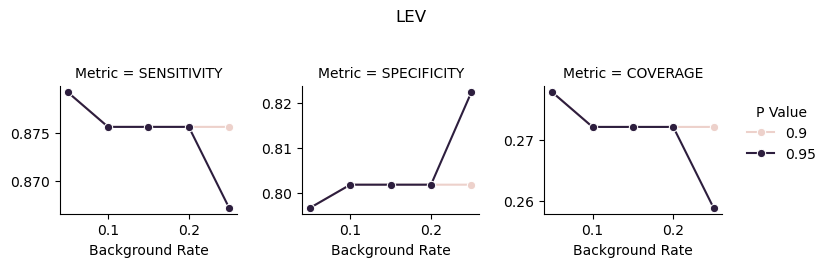

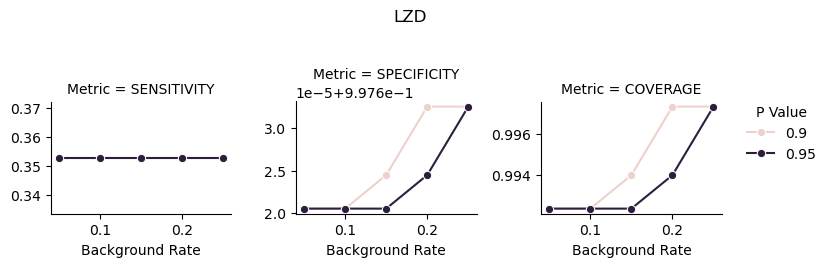

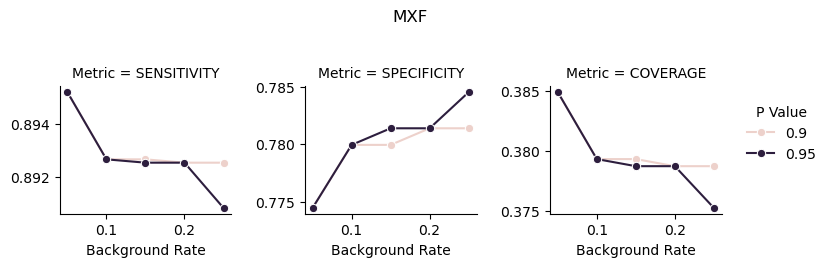

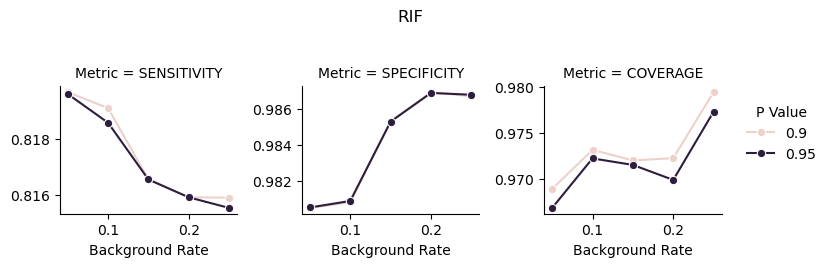

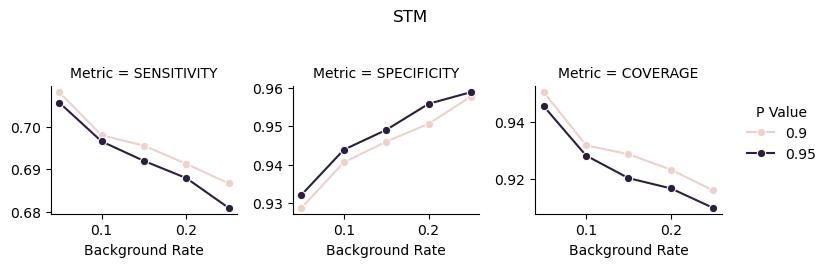

In [544]:
df = flatten_grid_results(grid_results_v1)

melted_df = df.melt(
    id_vars=["DRUG", "BACKGROUND_RATE", "p_value"],
    value_vars=["SENSITIVITY", "SPECIFICITY", "COVERAGE"],
    var_name="Metric",
    value_name="Value",
)

for drug in melted_df["DRUG"].unique():
    drug_data = melted_df[melted_df["DRUG"] == drug]
    g = sns.FacetGrid(drug_data, col="Metric", col_wrap=3, sharey=False, height=2.5)
    g.map_dataframe(
        sns.lineplot, x="BACKGROUND_RATE", y="Value", hue="p_value", marker="o"
    )
    g.set_axis_labels("Background Rate", "")
    g.add_legend(title="P Value")
    g.figure.suptitle(drug, y=1.05)
    g.tight_layout()
    plt.show()

In [558]:

opt_cats_v1 = utils.weighted_score(df).groupby("DRUG").head(1).reset_index(drop=True)
cat_counts = pd.DataFrame([
    {
        "DRUG": opt_cats_v1['DRUG'][i],
        "R": cat["PREDICTION"].value_counts().get("R", 0),
        "S": cat["PREDICTION"].value_counts().get("S", 0),
        "U": cat["PREDICTION"].value_counts().get("U", 0),
        "Total": len(cat)
    }
    for i in opt_cats_v1.index
    for cat in [pd.read_csv(f"./catalogues/cryptic-v1/grid_search/{opt_cats_v1['DRUG'][i].lower()}/bg_{opt_cats_v1['BACKGROUND_RATE'][i]}_p_{opt_cats_v1['p_value'][i]}_FRS_0.1.csv")]
])

opt_cats_v1 = pd.merge(opt_cats_v1, cat_counts, on='DRUG')
opt_cats_v1['catalogue'] = 'catomatic_v1'


In [546]:
#calculate WHOv1 performance on the cryptic-v1 training set (which should be the same as whov1's)
FRS = 0.1
whov1_results = {}

for drug, genes in drug_genes.items():
    who_catalogue = 'catalogues/whov1/NC_000962.3_WHO-UCN-GTB-PCI-2021.7_v1.0_GARC1_RUS.csv'
    if drug in pd.read_csv(who_catalogue)['DRUG'].unique():
        mutations = prep_mutations('data/mutations-v3.0.0/', genes, train=False)
        phenotypes = prep_phenotypes(drug, "data/cryptic-tables-v3.0.0-alpha.1/DST_MEASUREMENTS.pkl.gz", "data/cryptic-tables-v1/GENOMES.pkl.gz", "data/cryptic-tables-v1/DST_SAMPLES.csv.gz",)
        
        # Test the performance of the WHO on the training + synonymous set for this drug
        all = pd.merge(phenotypes, mutations[mutations.FRS >= 0.1], on=['UNIQUEID'], how='left')
        cm, cov, sens, spec, _, _ = utils.piezo_predict(iso_df=all, drug=drug, catalogue_file=who_catalogue, U_to_S=False, Print=False)
        
        # Save results into grid_results
        whov1_results[drug] = {'catalogue': 'WHOv1', "SENSITIVITY": sens, "SPECIFICITY": spec, "COVERAGE": cov}

whov1_results = pd.DataFrame(whov1_results).T.reset_index().rename(columns={'index':'DRUG'})

comp_train_perf_v1 = pd.concat([whov1_results, opt_cats_v1[opt_cats_v1.DRUG.isin(pd.read_csv(who_catalogue)['DRUG'].unique())][['DRUG', 'catalogue', 'SENSITIVITY', 'SPECIFICITY', 'COVERAGE']]], ignore_index=True).sort_values(by=['DRUG', 'catalogue'])
comp_train_perf_v1

,DRUG,catalogue,SENSITIVITY,SPECIFICITY,COVERAGE
0,AMI,WHOv1,0.0,1.0,0.782159
15,AMI,catomatic_v1,0.752801,0.985218,0.907563
1,CAP,WHOv1,0.168168,0.998627,0.825695
18,CAP,catomatic_v1,0.707216,0.979315,0.93294
2,DLM,WHOv1,0.10989,0.99969,0.98927
23,DLM,catomatic_v1,0.235849,0.99969,0.990789
3,EMB,WHOv1,0.791929,0.920472,0.865969
16,EMB,catomatic_v1,0.783064,0.92884,0.915917
4,ETH,WHOv1,0.836237,0.904062,0.863272
14,ETH,catomatic_v1,0.846308,0.886933,0.913452


/Users/dylanadlard/miniforge3/envs/cryptic-catalogues-25/lib/python3.13/site-packages/seaborn/categorical.py:383: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(n - .5, -.5, auto=None)


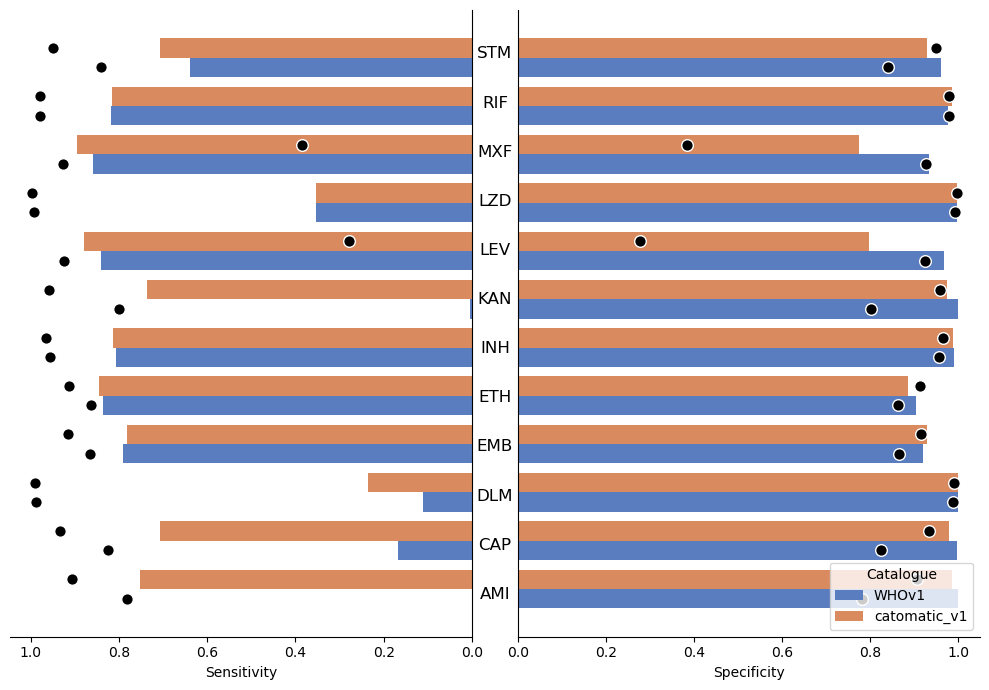

In [596]:
utils.back2back_sens_spec(comp_train_perf_v1)

#### Compare WHOv1 and catomatic1 contents:

In [ ]:
#Prep data for comparisons:
who = pd.read_csv('catalogues/whov1/NC_000962.3_WHO-UCN-GTB-PCI-2021.7_v1.0_GARC1_RUS.csv')
who['CATALOGUE_VERSION'] = 0
who['CATALOGUE_NAME'] = '-'
who['EVIDENCE'] = who['EVIDENCE'].apply(utils.str_to_dict)
who = who[~who['EVIDENCE'].apply(lambda x: isinstance(x, dict) and 'reporting_rule' in x)]
u_who = who[~who.PREDICTION.isin(['R','S'])]
who = who[who.PREDICTION.isin(['R','S'])]

valid_drugs = opt_cats_v1[opt_cats_v1.DRUG.isin(who.DRUG.unique())]
cats = valid_drugs.apply(
    lambda row: pd.read_csv(f"./catalogues/cryptic-v1/grid_search/{row['DRUG'].lower()}/bg_{row['BACKGROUND_RATE']}_p_{row['p_value']}_FRS_0.1.csv"),
    axis=1
).tolist()
cat = pd.concat(cats)
cat['CATALOGUE_VERSION'] = 0
cat['CATALOGUE_NAME'] = '-'
cat['EVIDENCE'] = cat['EVIDENCE'].apply(utils.str_to_dict)
cat = cat[~cat['EVIDENCE'].apply(lambda x: isinstance(x, dict) and 'default_rule' in x)]
u_cat = cat[~cat.PREDICTION.isin(['R','S'])]
cat = cat[cat.PREDICTION.isin(['R','S'])]

valid_drugs = cat[cat.DRUG.isin(who.DRUG.unique())].DRUG.unique()

In [ ]:
#pull out R and S counts
def extract_value(value, *keys):
    try:
        for key in keys:
            value = value[key]
        return value
    except (KeyError, IndexError, TypeError):
        return None
    
expanded_catalogues = utils.expand_catalogue_pair(cat, who, valid_drugs, 'RUS', ('cat', 'who'))

for drug, v in expanded_catalogues.items():
    v['merged']['solo_R_who'] = v['merged']['EVIDENCE_who'].apply(lambda x: extract_value(x, 'Present_SOLO_R'))
    v['merged']['solo_S_who'] = v['merged']['EVIDENCE_who'].apply(lambda x: extract_value(x, 'Present_S'))
    v['merged']['solo_R_cat'] = v['merged']['EVIDENCE_cat'].apply(lambda x: extract_value(x, 'contingency', 0, 0))
    v['merged']['solo_S_cat'] = v['merged']['EVIDENCE_cat'].apply(lambda x: extract_value(x, 'contingency', 0, 1))

all_drugs_merged = pd.concat(expanded_catalogues[drug]['merged'] for drug in valid_drugs)
all_drugs_merged['PREDICTION_PAIR'] = all_drugs_merged.apply(utils.classify_predictions, axis=1)
all_drugs_merged['DRUG'] = all_drugs_merged['DRUG_who'].combine_first(all_drugs_merged['DRUG_cat'])

shared = utils.sum_solo_counts(all_drugs_merged[~all_drugs_merged.PREDICTION_PAIR.str.contains('X')])
not_shared = utils.sum_solo_counts(all_drugs_merged[(all_drugs_merged.PREDICTION_PAIR.str.contains('X'))]).reset_index()

u_who['solo_R'] = u_who['EVIDENCE'].apply(lambda x: extract_value(x, 'Present_SOLO_R'))
u_who['solo_S'] = u_who['EVIDENCE'].apply(lambda x: extract_value(x, 'Present_S'))
u_cat['solo_R'] = u_cat['EVIDENCE'].apply(lambda x: extract_value(x, 'contingency', 0, 0))
u_cat['solo_S'] = u_cat['EVIDENCE'].apply(lambda x: extract_value(x, 'contingency', 0, 1))

#fill up the not_shared df with solo counts (as these had been discounted above if in the u df)
for i in range(len(not_shared)):
    drug = not_shared.DRUG.iloc[i]
    mutation = not_shared.MUTATION.iloc[i]
    if pd.isna(not_shared.y.iloc[i]):
        if mutation in u_who[u_who.DRUG==drug].MUTATION.tolist():            
            not_shared.loc[i, 'solo_R_who'] = u_who[(u_who.DRUG==drug)&(u_who.MUTATION==mutation)].solo_R.values[0]
            not_shared.loc[i, 'solo_S_who'] = u_who[(u_who.DRUG==drug)&(u_who.MUTATION==mutation)].solo_S.values[0]
    if pd.isna(not_shared.x.iloc[i]):
        if mutation in u_cat[u_cat.DRUG==drug].MUTATION.tolist():
            not_shared.loc[i, 'solo_R_cat'] = u_cat[(u_cat.DRUG==drug)&(u_cat.MUTATION==mutation)].solo_R.values[0]
            not_shared.loc[i, 'solo_S_cat'] = u_cat[(u_cat.DRUG==drug)&(u_cat.MUTATION==mutation)].solo_S.values[0]
#re-add up x and y columns
not_shared = utils.sum_solo_counts(not_shared)


### Compare Performance of WHOv2 and catomaticv3 and whov1 and catomaticv1 on crypticv3

In [692]:
#calculate WHOv2 performance on cryptic v3.0.0
FRS = 0.1
results = {}
catalogue_paths = {'WHOv1':'catalogues/whov1/NC_000962.3_WHO-UCN-GTB-PCI-2021.7_v1.0_GARC1_RUS.csv', 'WHOv2':'./data/old/NC_000962.3_WHO-UCN-TB-2023.5_v2.0_GARC1_RFUS.csv', 'catomaticv1':f"./catalogues/cryptic-v1/grid_search/{drug.lower()}/bg_{opt_cats_v1[opt_cats_v1.DRUG==drug]['BACKGROUND_RATE'].iloc[0]}_p_{opt_cats_v1[opt_cats_v1.DRUG==drug]['p_value'].iloc[0]}_FRS_0.1.csv"}
for drug, genes in drug_genes.items():
    if drug in pd.read_csv(catalogue_paths['WHOv2'])['DRUG'].unique():
        for catalogue, path in catalogue_paths.items():
            mutations = prep_mutations('data/mutations-v3.0.0/', genes, train=False)
            phenotypes = prep_phenotypes(drug, 'data/cryptic-tables-v3.0.0-alpha.1/DST_MEASUREMENTS.pkl.gz', 'data/cryptic-tables-v3.0.0-alpha.1/GENOMES.parquet', 'data/cryptic-tables-v3.0.0-alpha.1/DST_SAMPLES.parquet')
            # Test the performance of the WHO on the training set for this drug
            all = pd.merge(phenotypes, mutations[mutations.FRS >= 0.1], on=['UNIQUEID'], how='left')
            cm, cov, sens, spec, _, _ = utils.piezo_predict(iso_df=all, drug=drug, catalogue_file=path, U_to_S=False, Print=False)
            results[drug] = {'catalogue': catalogue, "SENSITIVITY": sens, "SPECIFICITY": spec, "COVERAGE": cov}

results = pd.DataFrame(results).T.reset_index().rename(columns={'index':'DRUG'})

comp_train_perf = pd.concat([results, opt_cats[opt_cats.DRUG.isin(pd.read_csv(who_catalogue)['DRUG'].unique())][['DRUG', 'catalogue', 'SENSITIVITY', 'SPECIFICITY', 'COVERAGE']]], ignore_index=True).sort_values(by=['DRUG', 'catalogue'])
comp_train_perf

KeyboardInterrupt: 

/Users/dylanadlard/miniforge3/envs/cryptic-catalogues-25/lib/python3.13/site-packages/seaborn/categorical.py:383: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(n - .5, -.5, auto=None)


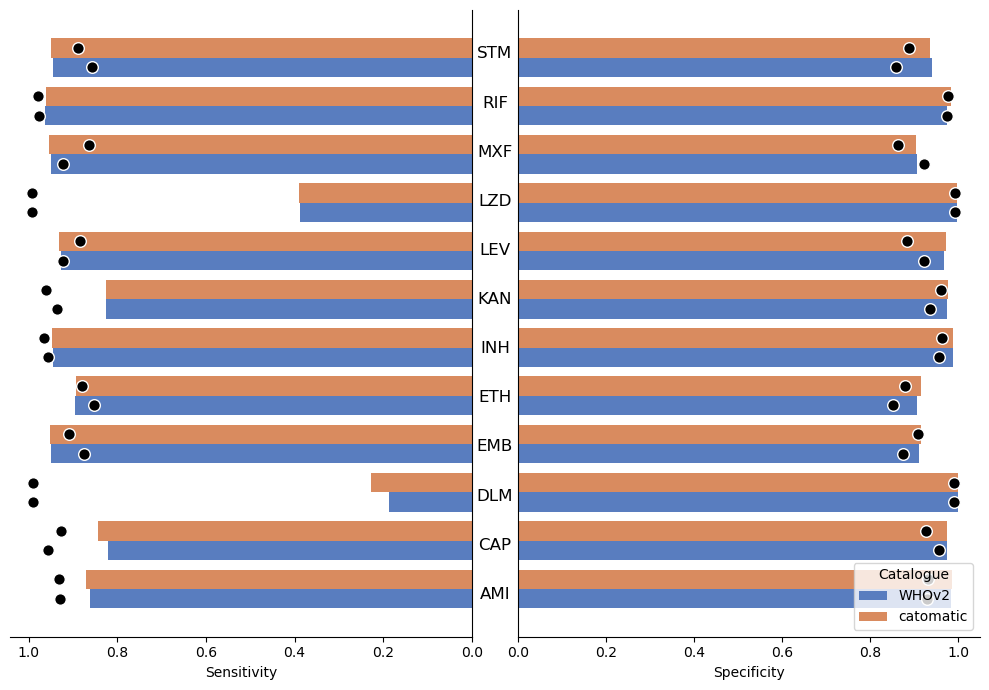

In [ ]:
utils.back2back_sens_spec(comp_train_perf)

 ### Compare with WHOv2 performance (validation set)

In [ ]:
#Calculate catomatic catalogue performance on validation set: 

FRS = 0.1
catomatic_results = {}

for drug, genes in drug_genes.items():

    who_catalogue = './data/old/NC_000962.3_WHO-UCN-TB-2023.5_v2.0_GARC1_RFUS.csv'
    if drug in pd.read_csv(who_catalogue)['DRUG'].unique():
        
        catfile=(f"./catalogues/grid_search/{drug.lower()}/bg_{opt_cats[opt_cats.DRUG==drug]['BACKGROUND_RATE'].iloc[0]}_"
                 f"p_{opt_cats[opt_cats.DRUG==drug]['p_value'].iloc[0]}_FRS_{FRS}.csv")
        mutations = prep_mutations('data/mutations-v3.0.0/', genes, train=False)
        phenotypes = prep_phenotypes(drug)
        #if validation data actually contains the drug
        if len(phenotypes)>0:
            # Test the performance of the WHO on the training set for this drug
            all = pd.merge(phenotypes, mutations[mutations.FRS >= 0.1], on=['UNIQUEID'], how='left')
            cm, cov, sens, spec, _, _ = utils.piezo_predict(iso_df=all, drug=drug, catalogue_file=catfile, U_to_S=False, Print=False)
            
            # Save results into grid_results
            catomatic_results[drug] = {'catalogue': 'catomatic', "SENSITIVITY": sens, "SPECIFICITY": spec, "COVERAGE": cov}

AMI
CAP
DLM
EMB
INH
KAN
LEV
LZD
MXF
RIF


## Compare content to WHOv2

The complications are:
- Both contains default rules
- Both contain expert rules (such as lof rules)

Therefore, how do we compare across - as a LoF in 1 will cover all such mutatations in the other, but some of these may be false positives, for example. 

If we want a comparison of effective content, then we should include the expert rules. But need to be careful, as there is a hierarchy to the rules.

The best thing to do is use piezo, which will handle what the rules actually mean and what falls under them.

But then should also highlight which of these matches/mismathces are due to rules, so can evaluate ability of the catalogue building step.

In the case of cat1 having rules, and cat2 not (e.g) - could just replace the rule with all the relevant entries in cat2 - this should then count them up correctly (irrespetive of phenotype matches). Need to be careful though, as catomatic cataogue may contain rule + specific variant, so just make sure duplicates are dropped after the merge and specific mutations are prioritised.

The way to think about it, is not a comparison of how many rows in each catalogue. But rather is a number of total specific mutations explicitly represented by both catalogues, some are specificly defined and some are encoded in rules. We can compare how many of these both catalogues cover.


In [591]:
#Prep data for comparisons:
who = pd.read_csv('./data/old/NC_000962.3_WHO-UCN-TB-2023.5_v2.0_GARC1_RFUS.csv')
who['EVIDENCE'] = who['EVIDENCE'].apply(utils.str_to_dict)
who['CATALOGUE_VERSION'] = 0
who['CATALOGUE_NAME'] = '-'
#filter out default rules
who = who[~who['EVIDENCE'].apply(lambda x: isinstance(x, dict) and 'reporting_rule' in x)]
#keep only R and S classifications
u_who = who[~who.PREDICTION.isin(['R','S'])]
who = who[who.PREDICTION.isin(['R','S'])]



#prep catomatic catalogues
valid_drugs = opt_cats[opt_cats.DRUG.isin(who.DRUG.unique())]
cats = valid_drugs.apply(
    lambda row: pd.read_csv(f"./catalogues/cryptic-v3.0.0/grid_search/{row['DRUG'].lower()}/bg_{row['BACKGROUND_RATE']}_p_{row['p_value']}_FRS_0.1.csv"),
    axis=1
).tolist()
cat = pd.concat(cats)
cat['CATALOGUE_VERSION'] = 0
cat['CATALOGUE_NAME'] = '-'
cat['EVIDENCE'] = cat['EVIDENCE'].apply(utils.str_to_dict)
#filter out default rules
cat = cat[~cat['EVIDENCE'].apply(lambda x: isinstance(x, dict) and 'default_rule' in x)]
#keep only R and S classifications
u_cat = cat[~cat.PREDICTION.isin(['R','S'])]
cat = cat[cat.PREDICTION.isin(['R','S'])]


valid_drugs = cat[cat.DRUG.isin(who.DRUG.unique())].DRUG.unique()


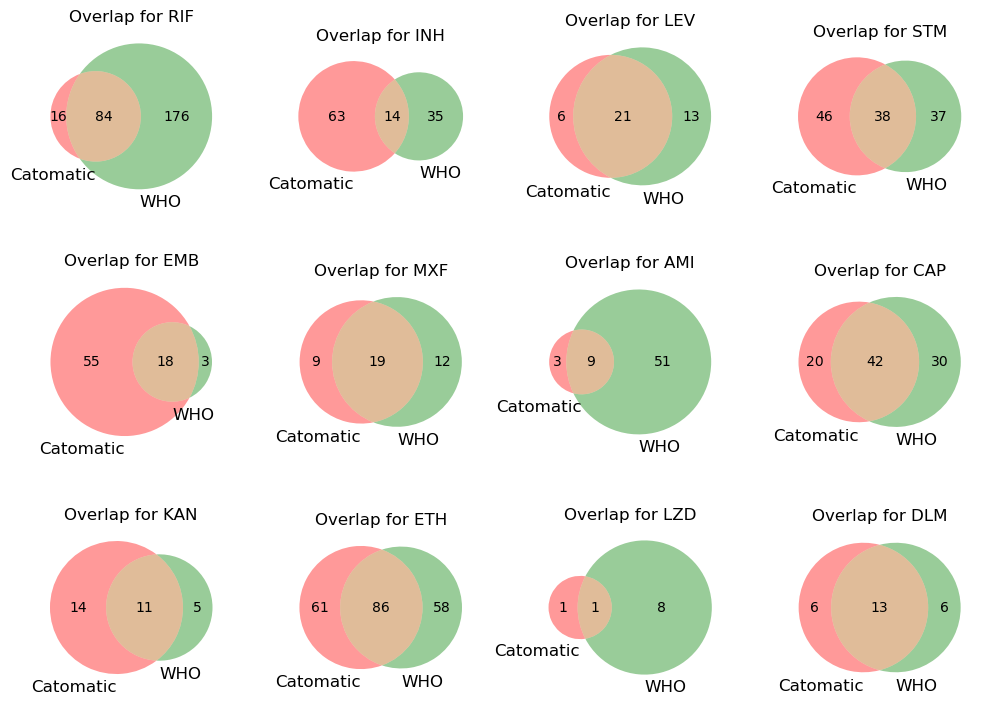

In [ ]:

expanded_catalogues = utils.expand_catalogue_pair(cat, who, valid_drugs, 'RFUS', ('cat', 'who'))

n_cols = 4
n_rows = -(-len(valid_drugs) // n_cols)  # Calculate rows based on number of drugs

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2.5, n_rows * 2.5))
axes = axes.flatten()

idx=0
for drug, v in expanded_catalogues.items():
    
    merged = v['merged']
    shared_variants = len(merged[(~merged.PREDICTION_who.isna()) & (~merged.PREDICTION_cat.isna())])
    who_only_variants = len(merged[(~merged.PREDICTION_who.isna()) & (merged.PREDICTION_cat.isna())])
    catomatic_only_variants = len(merged[(merged.PREDICTION_who.isna()) & (~merged.PREDICTION_cat.isna())])

    ax = axes[idx]
    venn_diagram = venn2(
        subsets=(catomatic_only_variants, who_only_variants, shared_variants),
        set_labels=('Catomatic', 'WHO'),
        ax=ax
    )
    ax.set_title(f"Overlap for {drug}")
    idx+=1

for ax in axes[len(valid_drugs):]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()

Can plot the number of solo counts observed for each variant shared across catalogues (not including rules, as the number of counrs in a rule can't be expanded to represent the counts of indvidual mutaitons that fall under that rule (ie the number of points will be less than the shared counts above, which include the rules) - this is automatically handled as the evidence columns for variants expanded from rules dont contain counts).

Could perhaps also plot proportion of resistance?

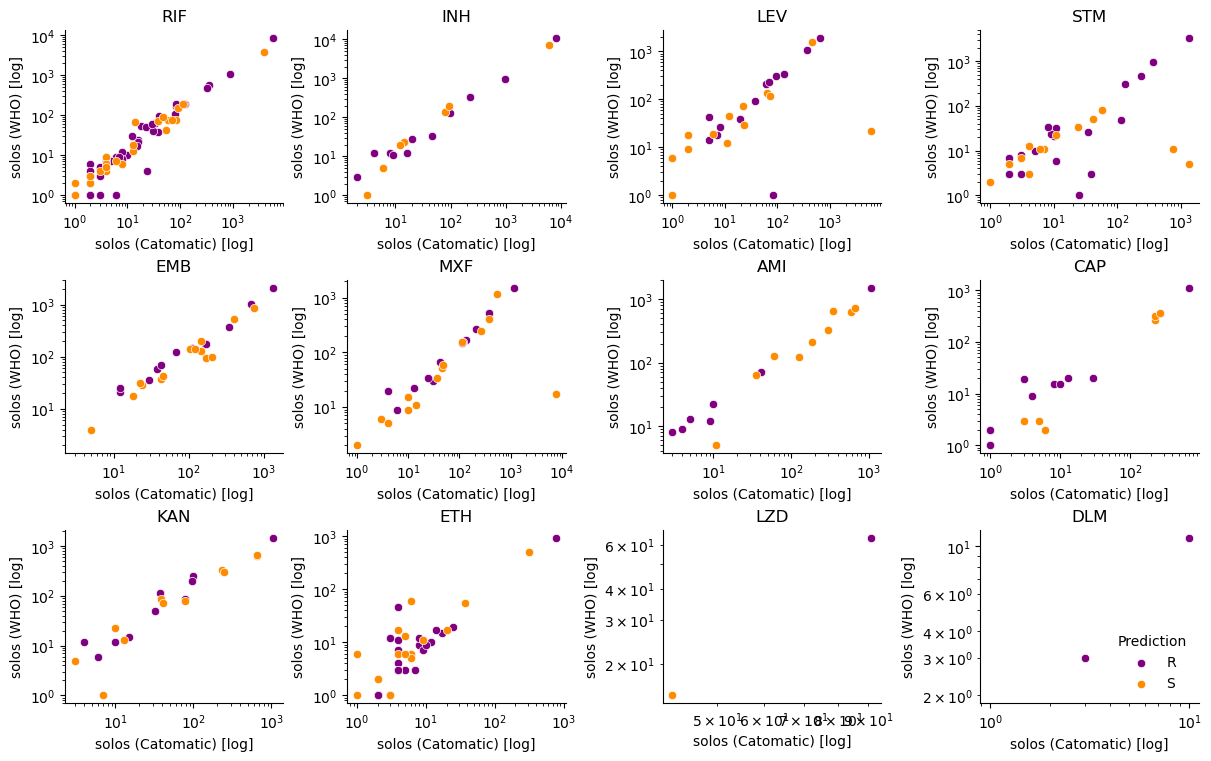

In [185]:
n_cols = 4  # Number of columns
n_rows = math.ceil(len(valid_drugs) / n_cols)  # Calculate rows needed
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 2.5 * n_rows), constrained_layout=True)

axes = axes.flatten()

idx=0
for drug, v in expanded_catalogues.items():

    shared = v['merged'][(~v['merged'].PREDICTION_who.isna())&(~v['merged'].PREDICTION_cat.isna())]
    
    ax = axes[idx]
    sns.scatterplot(data=shared, x='solo_R_cat', y='solo_R_who', ax=ax, color='purple', label='R')
    sns.scatterplot(data=shared, x='solo_S_cat', y='solo_S_who', ax=ax, color='darkorange', label='S')

    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_title(f"{drug}")
    ax.set_xlabel("solos (Catomatic) [log]")
    ax.set_ylabel("solos (WHO) [log]")
    sns.despine(ax=ax)
    if idx == len(valid_drugs)-1:
        ax.legend(title="Prediction", frameon=False, loc='lower right')
    else:
        ax.legend().remove()
    
    idx += 1
    
# Hide unused subplots if any
for j in range(idx , len(axes)):
    axes[j].axis('off')

# Show the grid of plots
plt.show()


In [186]:
def classify_predictions(row):
    if not pd.isna(row['PREDICTION_who']) and not pd.isna(row['PREDICTION_cat']):
        return f"{row['PREDICTION_cat']}.{row['PREDICTION_who']}"
    elif pd.isna(row['PREDICTION_who']) and not pd.isna(row['PREDICTION_cat']):
        return f"{row['PREDICTION_cat']}.X"
    elif not pd.isna(row['PREDICTION_who']) and pd.isna(row['PREDICTION_cat']):
        return f"X.{row['PREDICTION_who']}"
    else:
        return "X.X"  # Default case if both are NaN


all_drugs_merged = pd.concat(expanded_catalogues[drug]['merged'] for drug in valid_drugs)

all_drugs_merged['PREDICTION_PAIR'] = all_drugs_merged.apply(classify_predictions, axis=1)

all_drugs_merged['DRUG'] = all_drugs_merged['DRUG_who'].combine_first(all_drugs_merged['DRUG_cat'])


The below is a finer grain summary of what each catalogue contains, taking into account expert rules as above. The sum of these should match the venn diagrams above.

In [248]:
#all_drugs_merged can contain duplicate mutations if catalogue contians both a row and rule that mutation falls under (ie if duplicate in the original catalogue)
#want to keep these in for diagnosis, but must be careful to filter our for counts and figures

summary_table = (
    all_drugs_merged.drop_duplicates(['MUTATION']).groupby(['DRUG', 'PREDICTION_PAIR'])
    .size()
    .unstack(fill_value=0)  # Pivot table to create columns for prediction pairs
    .reset_index()  # Resets the index, moving 'PREDICTION_PAIR' into a column
)

summary_table.rename(columns={'DRUG': 'DRUG'}, inplace=True)
summary_table['total'] = summary_table.drop(columns=['DRUG']).sum(axis=1)
summary_table.columns.name = None

summary_table

,DRUG,R.R,R.X,S.R,S.S,S.X,X.R,X.S,total
0,AMI,3,0,0,2,2,1,48,56
1,CAP,34,20,0,0,0,8,2,64
2,DLM,10,6,0,0,0,6,0,22
3,EMB,12,5,0,6,50,1,2,76
4,ETH,67,58,0,0,2,54,2,183
5,INH,12,45,0,2,18,32,3,112
6,KAN,1,0,0,0,9,1,1,12
7,LEV,11,1,0,10,5,7,6,40
8,LZD,1,1,0,0,0,7,1,10
9,MXF,0,0,0,0,2,0,0,2


Ignoring rules (as cant plot individual isoalte counts, unless the specific mutation is also included as a seperate row), the plots below give the number of isolates used in the classifications, and the repsetive predicted phenotypes, for variants that are either in both catalogues with R/S labels, or for variants only in 1 catalogue.

Helps identify the kind of phenotype mismathces being made, and the amount of data behind each mismatch.

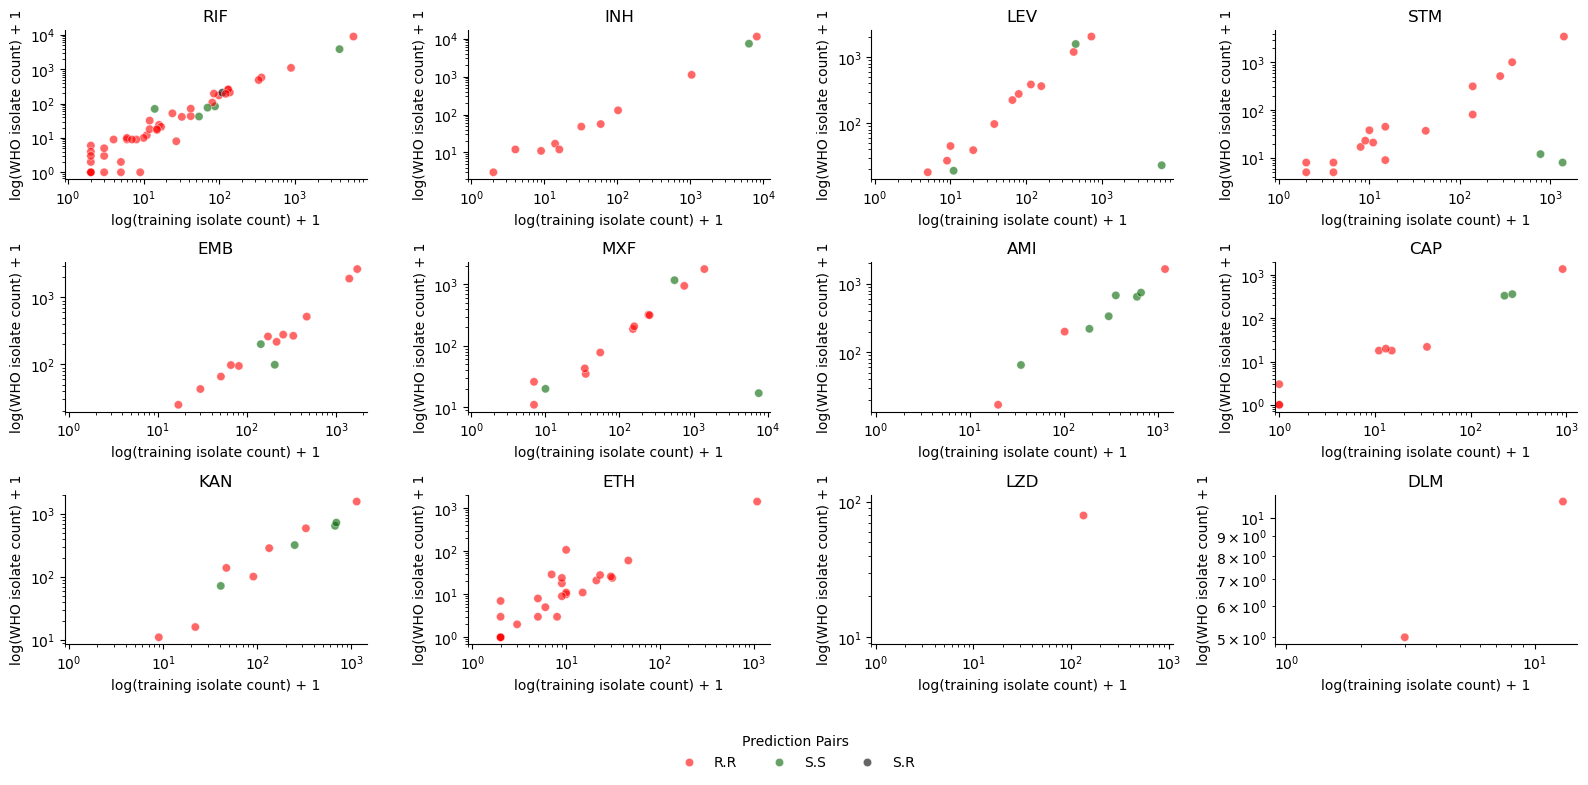

In [276]:

prediction_colors = {
    "R.R": "red", "S.S": "darkgreen", "R.S": "grey", "S.R": "black",
    "X.S": "black", "X.R": "darkorange",
    "S.X": "lightblue", "R.X": "purple",
}


def plot_grid_counts(df):
    n_cols = 4
    n_rows = int(np.ceil(len(valid_drugs) / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 2.5 * n_rows))

    axes = axes.flatten()
    all_handles = {}  # Store all unique legend handles

    idx = 0
    for drug in valid_drugs:
        ax = axes[idx]
        scatter = sns.scatterplot(
            data=df[df.DRUG == drug], 
            x="x", y="y", 
            hue="PREDICTION_PAIR", palette=prediction_colors, 
            alpha=0.6, ax=ax
        )

        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xlim(left=0.9)
        ax.set_title(drug)
        ax.set_xlabel("log(training isolate count) + 1")
        ax.set_ylabel("log(WHO isolate count) + 1")
        sns.despine(ax=ax)

        # Collect all unique legend handles
        handles, labels = ax.get_legend_handles_labels()
        for h, l in zip(handles, labels):
            all_handles[l] = h  # Store unique labels to avoid duplicates

        ax.get_legend().remove()  # Remove subplot legends

        idx += 1

    # Hide unused subplots
    for j in range(len(valid_drugs), len(axes)):
        axes[j].axis('off')

    # Create a single legend above all plots
    if all_handles:
        fig.legend(all_handles.values(), all_handles.keys(), 
                title="Prediction Pairs", loc='lower center', 
                bbox_to_anchor=(0.5, -0.1), ncol=len(all_handles), frameon=False)

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit legend
    plt.show()

# Filter data
shared = utils.sum_solo_counts(all_drugs_merged[~all_drugs_merged.PREDICTION_PAIR.str.contains('X')])

# Plot the grid (ignoring rules, as these won't have counts)
plot_grid_counts(shared[(shared.EVIDENCE_who != {'expanded_rule'}) & (shared.EVIDENCE_cat != {'expanded_rule'})])


Of all the mutations in both catalogues, the only ones classified differently are 3 Rif variants where we have predicted S but WHO R:

In [447]:
shared[(shared.PREDICTION_PAIR=='S.R')]

,GENBANK_REFERENCE_who,CATALOGUE_NAME_who,CATALOGUE_VERSION_who,CATALOGUE_GRAMMAR_who,PREDICTION_VALUES_who,DRUG_who,MUTATION,PREDICTION_who,SOURCE_who,EVIDENCE_who,...,EVIDENCE_cat,OTHER_cat,solo_R_who,solo_S_who,solo_R_cat,solo_S_cat,PREDICTION_PAIR,DRUG,x,y
172,NC_000962.3,WHO-UCN-GTB-PCI-2023.5,2.0,GARC1,RFUS,RIF,rpoB@L430P,R,{},"{'Observed_samples': {'Present_SOLO_SR': 208, ...",...,"{'proportion': 0.16363636363636364, 'confidenc...",{},53.0,155.0,18.0,92.0,S.R,RIF,110.0,208.0
173,NC_000962.3,WHO-UCN-GTB-PCI-2023.5,2.0,GARC1,RFUS,RIF,rpoB@L430P,R,{},{expanded_rule},...,"{'proportion': 0.16363636363636364, 'confidenc...",{},NaN,NaN,18.0,92.0,S.R,RIF,110.0,NaN
179,NC_000962.3,WHO-UCN-GTB-PCI-2023.5,2.0,GARC1,RFUS,RIF,rpoB@L449Q,R,{},{expanded_rule},...,"{'proportion': 0.0, 'confidence': [-3.26846996...",{},NaN,NaN,0.0,44.0,S.R,RIF,44.0,NaN


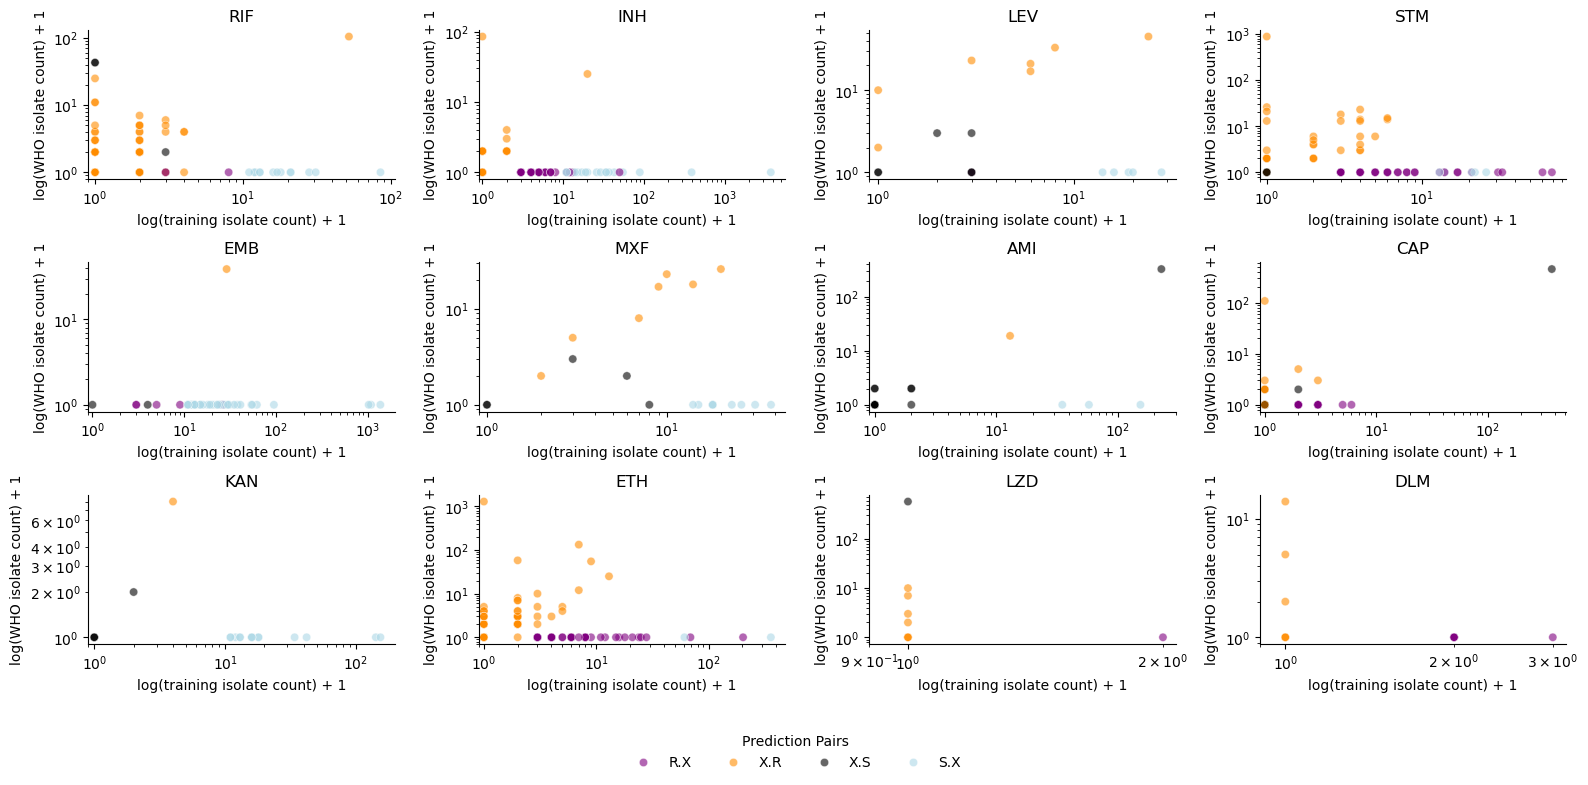

In [441]:
not_shared = utils.sum_counts(all_drugs_merged[(all_drugs_merged.PREDICTION_PAIR.str.contains('X'))])
not_shared['expert_rule'] = not_shared['EVIDENCE_who'].apply(lambda x: extract_value(x, 'expert_rule'))
not_shared = not_shared[not_shared['expert_rule'].isna()].reset_index(drop=True)

#crate solo counts columns for catalogues with only Us
u_who['solo_R'] = u_who['EVIDENCE'].apply(lambda x: extract_value(x, 'Observed_samples', 'Present_SOLO_R'))
u_who['solo_S'] = u_who['EVIDENCE'].apply(lambda x: extract_value(x, 'Observed_samples', 'Present_SOLO_S'))
u_cat['solo_R'] = u_cat['EVIDENCE'].apply(lambda x: extract_value(x, 'contingency', 0, 0))
u_cat['solo_S'] = u_cat['EVIDENCE'].apply(lambda x: extract_value(x, 'contingency', 0, 1))

#fill up the not_shared df with solo counts (as these had been discounted above)
for i in range(len(not_shared)):
    drug = not_shared.DRUG.iloc[i]
    mutation = not_shared.MUTATION.iloc[i]
    if pd.isna(not_shared.y.iloc[i]):
        if mutation in u_who[u_who.DRUG==drug].MUTATION.tolist():            
            not_shared.loc[i, 'solo_R_who'] = u_who[(u_who.DRUG==drug)&(u_who.MUTATION==mutation)].solo_R.values[0]
            not_shared.loc[i, 'solo_S_who'] = u_who[(u_who.DRUG==drug)&(u_who.MUTATION==mutation)].solo_S.values[0]
    if pd.isna(not_shared.x.iloc[i]):
        if mutation in u_cat[u_cat.DRUG==drug].MUTATION.tolist():
            not_shared.loc[i, 'solo_R_cat'] = u_cat[(u_cat.DRUG==drug)&(u_cat.MUTATION==mutation)].solo_R.values[0]
            not_shared.loc[i, 'solo_S_cat'] = u_cat[(u_cat.DRUG==drug)&(u_cat.MUTATION==mutation)].solo_S.values[0]

#re-add up x and y columns
not_shared = sum_counts(not_shared)

#to prevent breaking the log
not_shared['x'] = not_shared['x'].fillna(0)
not_shared['x'] += 1
not_shared['y'] = not_shared['y'].fillna(0)
not_shared['y'] += 1

plot_grid_counts(not_shared[(not_shared.EVIDENCE_who != {'expanded_rule'}) & (not_shared.EVIDENCE_cat != {'expanded_rule'})])

In [450]:
not_shared[(not_shared.DRUG=='EMB')&(not_shared.PREDICTION_PAIR=='X.R')]

,GENBANK_REFERENCE_who,CATALOGUE_NAME_who,CATALOGUE_VERSION_who,CATALOGUE_GRAMMAR_who,PREDICTION_VALUES_who,DRUG_who,MUTATION,PREDICTION_who,SOURCE_who,EVIDENCE_who,...,OTHER_cat,solo_R_who,solo_S_who,solo_R_cat,solo_S_cat,PREDICTION_PAIR,DRUG,x,y,expert_rule
374,NC_000962.3,WHO-UCN-GTB-PCI-2023.5,2.0,GARC1,RFUS,EMB,embB@Y319C,R,{},"{'Observed_samples': {'Present_SOLO_SR': 38, '...",...,NaN,16.0,22.0,10.0,18.0,X.R,EMB,29.0,39.0,None


Most of the X.R mismatches eem to stem from expanded RRDR rules? No solo counts, but stil in this translated version of the catalogue?